<a href="https://colab.research.google.com/github/lenonborges/Monitor-de-Ativos/blob/main/Experimentos_%2B_EDA_(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Importação de bibliotecas

In [ ]:
#pip install lazypredict
#pip install googletrans==4.0.0-rc1
#pip install textblob
#pip install vaderSentiment

In [2]:
#Manipulação de dados
import pandas as pd
import numpy as np

#Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

#Manipulação datas
from datetime import datetime

# Prototipação
from lazypredict.Supervised import LazyClassifier


#Pipeline e pré-process
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


#Models
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.neighbors import KNeighborsClassifier

#Model Tunning
from sklearn.model_selection import GridSearchCV

#Model evaluation
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# 2.0 Leitura dos arquivos

## Leitura de Noticias

In [3]:
dicionario_mes = {'Jan':'01', 'Fev':'02', 'Mar':'03','Abr':'04', 'Mai':'05', 'Jun':'06','Jul':'07', 'Ago':'08', 'Set':'09','Out':'10', 'Nov':'11', 'Dec':'12'}

In [4]:
df = pd.DataFrame()

for i in dicionario_mes.keys():
    arquivo = dicionario_mes[i] + "_GoogleNews_Petr_" + i + "_21.csv"
    df_leitura = pd.read_csv(arquivo, sep='|')
    df = df.append(df_leitura,ignore_index=True)

In [5]:
df.head()

,title,media,date,desc
0,A construção naval brasileira tem chances de a...,CPG Click Petroleo e Gas,01/01/2021,Dentre os principais pontos do plano estratégi...
1,"Refinaria Abreu e Lima da Petrobras, a RNEST p...",CPG Click Petroleo e Gas,01/01/2021,Petrobras informou em fato relevante na última...
2,5 Dicas de Tony Robbins para Ficar Rico Invest...,The Capital Advisor,01/01/2021,O QUE LER AGORA... ibovespa-sobe-021-apos-demi...
3,Acadêmicos de engenharia Mecânica criam projet...,CPG Click Petroleo e Gas,01/01/2021,Petrobras cancela a venda da fábrica de fertil...
4,Multinacional dinamarquesa European Energy faz...,CPG Click Petroleo e Gas,01/01/2021,Petrobras encerra sociedade com a Sete Brasil ...


In [6]:
#Transformando coluna data para datetime:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

title            object
media            object
date     datetime64[ns]
desc             object
dtype: object

## Leitura dos pregões

In [7]:
df_petro = pd.read_csv('Hist_Preço_Petr_2021_.csv', sep='|')
df_petro.head()

,Date,Adj Close,Volume,Var%
0,2021-01-04,19.27,74719700,0.02
1,2021-01-05,20.03,95181100,0.04
2,2021-01-06,20.07,96562500,0.00
3,2021-01-07,20.67,56171300,0.03
4,2021-01-08,20.75,67136300,0.00


In [8]:
#Transformando a coluna Date para datetime
df_petro['Date'] = pd.to_datetime(df_petro['Date'])
df_petro.dtypes

Date         datetime64[ns]
Adj Close           float64
Volume                int64
Var%                float64
dtype: object

# 3.0 EDA
**H1:** Há uma média razoável de noticias diárias   - **VERDADEIRO**  
**H2:** Há poucos dias sem noticias na base de dados  - **VERDADEIRO**   
**H3:** Há dias em que o pregão da bolsa não funciona (Finais de Semana) **VERDADEIRO**  
**H4:**  
**H5:**  

## 3.1 H1: Há uma média razoável de noticias diárias

In [9]:
df.date.value_counts()

2021-08-05    10
2021-03-10    10
2021-05-21    10
2021-11-06    10
2021-03-03    10
              ..
2021-03-22     2
2021-04-04     2
2021-02-14     2
2021-08-15     2
2021-07-25     1
Name: date, Length: 327, dtype: int64

In [10]:
# Coletando as datas e as frequencias de noticias:
datas = df.date.value_counts()  
data_df = datas.reset_index()
data_df

,index,date
0,2021-08-05,10
1,2021-03-10,10
2,2021-05-21,10
3,2021-11-06,10
4,2021-03-03,10
...,...,...
322,2021-03-22,2
323,2021-04-04,2
324,2021-02-14,2
325,2021-08-15,2


In [11]:
#Visualizando os tipos dos dados
data_df.dtypes

index    datetime64[ns]
date              int64
dtype: object

In [12]:
#Alterando para o formato datetime
data_df['index'] = pd.to_datetime(data_df['index'])
data_df

,index,date
0,2021-08-05,10
1,2021-03-10,10
2,2021-05-21,10
3,2021-11-06,10
4,2021-03-03,10
...,...,...
322,2021-03-22,2
323,2021-04-04,2
324,2021-02-14,2
325,2021-08-15,2


In [13]:
# Organizando o dataframe em ordem cronologica
data_df.sort_values(by = 'index', ascending = True, inplace = True) 
data_df.tail()

,index,date
243,2021-12-27,10
100,2021-12-28,10
38,2021-12-29,10
193,2021-12-30,10
58,2021-12-31,10


In [14]:
data_df.describe()

,date
count,327.00
mean,9.25
std,1.77
min,1.00
25%,10.00
50%,10.00
75%,10.00
max,10.00


Há uma média de 9.25 (+- 2) noticias por dia

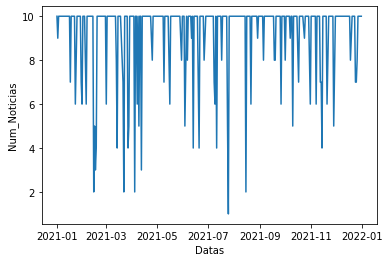

In [15]:
#Visualizando data vs quantidade de notícias
data_df.columns = ['Datas', 'Num_Noticias']
sns.lineplot(x = 'Datas', y = 'Num_Noticias', data = data_df)

In [16]:
# inserindo coluna de mês
data_df['Mes'] = data_df['Datas'].dt.month

# Calculando media de noticias por mês
df_noticia_mes = data_df.groupby('Mes').agg({'Num_Noticias':np.mean})
df_noticia_mes

,Num_Noticias
Mes,
1,9.44
2,8.89
3,8.67
4,9.00
5,9.64
6,9.19
7,8.88
8,9.54
9,9.64


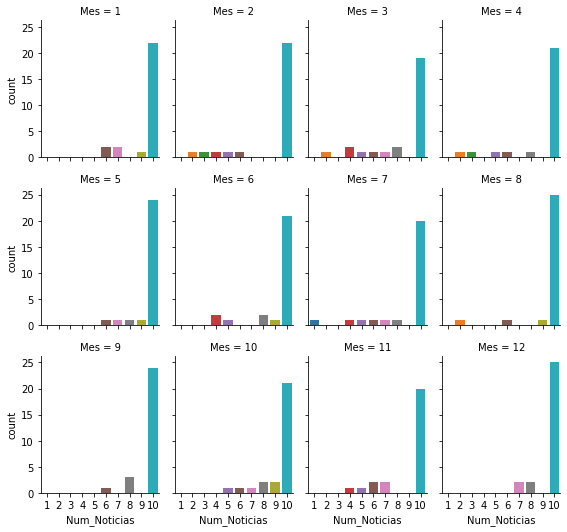

In [17]:
# Visualizando distribuição da quantidade de noticias ao longo dos meses
sns.catplot(x="Num_Noticias", col="Mes", col_wrap=4,
                data=data_df,
                kind="count", height=2.5, aspect=.8)

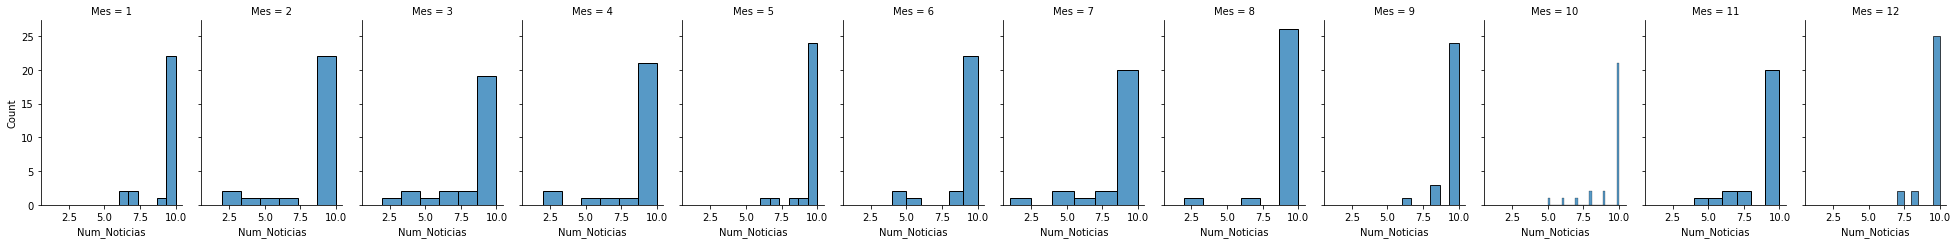

In [18]:
# Visualizando distribuição da quantidade de noticias ao longo dos meses
g = sns.FacetGrid(data_df, col="Mes", height=3.5, aspect=.65)
g.map(sns.histplot, "Num_Noticias")

Há poucas ocorrências de baixo numero de noticias por dia, a maior ocorrência da quantidade de noticias por dia é de 10.
Dessa forma, a média de noticias por mês varia de 8.6 á 9.65.

## 3.2 Há poucos dias sem noticias na base de dados

In [19]:
from datetime import datetime

In [20]:
## Gerando uma lista com todos os dias de 2021:
start_date = '01/01/2021'
end_date = '31/12/2021'

#Transformando para o padrão inglês
start_date = datetime.strptime(start_date, '%d/%m/%Y').strftime('%m-%d-%Y')
end_date = datetime.strptime(end_date, '%d/%m/%Y').strftime('%m-%d-%Y')

#Gerando a lista com todas as datas
todas_datas = pd.date_range(start=start_date, end=end_date, freq = '1D')
todas_datas = [i.strftime("%d/%m/%Y") for i in todas_datas ]

In [21]:
#Gerando lista com todas as datas com noticias
datas_com_noticias = [i.strftime("%d/%m/%Y") for i in data_df['Datas'] ]

In [22]:
#Gerando lista com todas as datas sem noticias em 2021
datas_sem_noticias = [i for i in todas_datas if i not in datas_com_noticias]
print("Há %s dias sem notícias em 2021!" % len(datas_sem_noticias))

Há 38 dias sem notícias em 2021!


Em apenas 38 dias de 2021 não houve retorno de noticias diárias da Petrobras

## 3.3 Há dias em que o pregão da bolsa não funciona (Finais de Semana)

In [23]:
datas_com_pregao = [i.strftime("%d/%m/%Y") for i in df_petro['Date'] ]

In [24]:
datas_sem_pregao = [i for i in todas_datas if i not in datas_com_pregao]

In [25]:
print("Há %s dias sem pregão em 2021!" % len(datas_sem_pregao))

Há 118 dias sem pregão em 2021!


# 4.0 Pré-Processamento

## 4.1 Padronização das palavras contidas nos títulos das noticias para minúsculo

In [26]:
df.head()

,title,media,date,desc
0,A construção naval brasileira tem chances de a...,CPG Click Petroleo e Gas,2021-01-01,Dentre os principais pontos do plano estratégi...
1,"Refinaria Abreu e Lima da Petrobras, a RNEST p...",CPG Click Petroleo e Gas,2021-01-01,Petrobras informou em fato relevante na última...
2,5 Dicas de Tony Robbins para Ficar Rico Invest...,The Capital Advisor,2021-01-01,O QUE LER AGORA... ibovespa-sobe-021-apos-demi...
3,Acadêmicos de engenharia Mecânica criam projet...,CPG Click Petroleo e Gas,2021-01-01,Petrobras cancela a venda da fábrica de fertil...
4,Multinacional dinamarquesa European Energy faz...,CPG Click Petroleo e Gas,2021-01-01,Petrobras encerra sociedade com a Sete Brasil ...


In [27]:
df['title'] = df['title'].apply(lambda x: x.lower())
df.head()

,title,media,date,desc
0,a construção naval brasileira tem chances de a...,CPG Click Petroleo e Gas,2021-01-01,Dentre os principais pontos do plano estratégi...
1,"refinaria abreu e lima da petrobras, a rnest p...",CPG Click Petroleo e Gas,2021-01-01,Petrobras informou em fato relevante na última...
2,5 dicas de tony robbins para ficar rico invest...,The Capital Advisor,2021-01-01,O QUE LER AGORA... ibovespa-sobe-021-apos-demi...
3,acadêmicos de engenharia mecânica criam projet...,CPG Click Petroleo e Gas,2021-01-01,Petrobras cancela a venda da fábrica de fertil...
4,multinacional dinamarquesa european energy faz...,CPG Click Petroleo e Gas,2021-01-01,Petrobras encerra sociedade com a Sete Brasil ...


## 4.2 Exclusão noticias que não contenham a palavra chave "Petrobras" no título
Embora tenha-se configurado A biblioteca GoogleNews() para baixar noticias pela palavra chave "Petrobras" pode ocorrer casos em que o termo não é citado no título e nem no corpo da noticia.

In [28]:
df.iloc[2][0]

'5 dicas de tony robbins para ficar rico investindo'

In [29]:
df.iloc[2][3]

'O QUE LER AGORA... ibovespa-sobe-021-apos-demissao-na-petrobras-prio3-.  Notícias. Ibovespa Sobe +0...'

Essa noticia "5 dicas de tony robbins para ficar rico investindo", por exemplo, não possui relação com a petrobras no título e nem no corpo do artigo ao checar direto na fonte em <https://comoinvestir.thecap.com.br/5-dicas-de-tony-robbins-para-ficar-rico-investindo>. A biblioteca GoogleNews() retornou essa noticia, pois, na pagina HTML há noticias recomendadas ao leitor que possuem a palavra chave "petrobras".

Noticias sem a palavra chave "petrobras" no título serão excluidas do dataset

In [30]:
df['title'] = df['title'].apply(lambda x: "" if "petrobras" not in x else x)
df

,title,media,date,desc
0,a construção naval brasileira tem chances de a...,CPG Click Petroleo e Gas,2021-01-01,Dentre os principais pontos do plano estratégi...
1,"refinaria abreu e lima da petrobras, a rnest p...",CPG Click Petroleo e Gas,2021-01-01,Petrobras informou em fato relevante na última...
2,,The Capital Advisor,2021-01-01,O QUE LER AGORA... ibovespa-sobe-021-apos-demi...
3,,CPG Click Petroleo e Gas,2021-01-01,Petrobras cancela a venda da fábrica de fertil...
4,,CPG Click Petroleo e Gas,2021-01-01,Petrobras encerra sociedade com a Sete Brasil ...
...,...,...,...,...
3021,quer trabalhar na petrobras? falta menos de um...,JC Online,2021-12-31,O processo seletivo público que oferece 757 va...
3022,,CNN Brasil,2021-12-31,"Para ele, a solução desta pressão não deve pas..."
3023,,PetroNotícias,2021-12-31,Isso porque a Petrobrás anunciou que registrou...
3024,unigel assina contratos para suprimento das fá...,CPG Click Petroleo e Gas,2021-12-31,No dia 27 de dezembro a Unigel fechou contrato...


In [31]:
df = df[(df['title'] != "")]
df

,title,media,date,desc
0,a construção naval brasileira tem chances de a...,CPG Click Petroleo e Gas,2021-01-01,Dentre os principais pontos do plano estratégi...
1,"refinaria abreu e lima da petrobras, a rnest p...",CPG Click Petroleo e Gas,2021-01-01,Petrobras informou em fato relevante na última...
26,petrobras é condenada em arbitragem iniciada p...,Forbes Brasil,2021-04-01,A Petrobras disse que a sentença determinou qu...
27,petrobras fez provisionamento para indenizar iesa,Valor Econômico,2021-04-01,Petrobras fez provisionamento para indenizar I...
28,"petrobras é condenada, nos eua, a indenizar a ...",Money Times,2021-04-01,A Petrobras (PETR3; PETR4) foi condenada por u...
...,...,...,...,...
3018,aumento do preço do gás encanado: justiça inti...,FDR,2021-12-31,"Na última quinta-feira, 30, a Petrobras recebe..."
3019,presidente da petrobras diz que eleições não v...,Jovem Pan,2021-12-31,"Para 2022, Joaquim Silva e Luna entende que a ..."
3020,"petrobras conclui venda de ativos do rn, em me...",Saiba Mais,2021-12-31,Após os trabalhadores aprovarem estado de grev...
3021,quer trabalhar na petrobras? falta menos de um...,JC Online,2021-12-31,O processo seletivo público que oferece 757 va...


1494 noticias não relacionadas ao termo "Petrobras" em seus títulos foram foram excluidas do dataset

## 4.4 Adição de classe "Fechamento" ao dataframe de Ações
Classe 1: Fechamento em alta  
Classe 0: Fechamento em queda  

In [32]:
df_petro

,Date,Adj Close,Volume,Var%
0,2021-01-04,19.27,74719700,0.02
1,2021-01-05,20.03,95181100,0.04
2,2021-01-06,20.07,96562500,0.00
3,2021-01-07,20.67,56171300,0.03
4,2021-01-08,20.75,67136300,0.00
...,...,...,...,...
242,2021-12-23,23.24,28713600,0.01
243,2021-12-27,23.58,44227900,0.01
244,2021-12-28,23.61,30688100,0.00
245,2021-12-29,23.41,35508400,-0.01


In [33]:
df_petro['Fechamento'] = df_petro['Var%'].apply(lambda x: 0 if x<0 else 1)
df_petro

,Date,Adj Close,Volume,Var%,Fechamento
0,2021-01-04,19.27,74719700,0.02,1
1,2021-01-05,20.03,95181100,0.04,1
2,2021-01-06,20.07,96562500,0.00,1
3,2021-01-07,20.67,56171300,0.03,1
4,2021-01-08,20.75,67136300,0.00,1
...,...,...,...,...,...
242,2021-12-23,23.24,28713600,0.01,1
243,2021-12-27,23.58,44227900,0.01,1
244,2021-12-28,23.61,30688100,0.00,1
245,2021-12-29,23.41,35508400,-0.01,0


In [34]:
df_petro.Fechamento.value_counts()

1    131
0    116
Name: Fechamento, dtype: int64

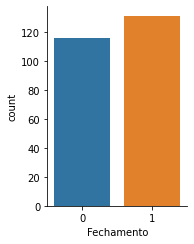

In [35]:
sns.catplot(x="Fechamento",
                data=df_petro,
                kind="count", height=3.5, aspect=.8)

Em 2021 houve 131 fechamentos com aumento nos valores de ações da Petrobras e 116 com fechamento em queda.

## 4.5 Concatenar noticias diárias

In [36]:
df_petro.head()

,Date,Adj Close,Volume,Var%,Fechamento
0,2021-01-04,19.27,74719700,0.02,1
1,2021-01-05,20.03,95181100,0.04,1
2,2021-01-06,20.07,96562500,0.00,1
3,2021-01-07,20.67,56171300,0.03,1
4,2021-01-08,20.75,67136300,0.00,1


In [37]:
df.head()

,title,media,date,desc
0,a construção naval brasileira tem chances de a...,CPG Click Petroleo e Gas,2021-01-01,Dentre os principais pontos do plano estratégi...
1,"refinaria abreu e lima da petrobras, a rnest p...",CPG Click Petroleo e Gas,2021-01-01,Petrobras informou em fato relevante na última...
26,petrobras é condenada em arbitragem iniciada p...,Forbes Brasil,2021-04-01,A Petrobras disse que a sentença determinou qu...
27,petrobras fez provisionamento para indenizar iesa,Valor Econômico,2021-04-01,Petrobras fez provisionamento para indenizar I...
28,"petrobras é condenada, nos eua, a indenizar a ...",Money Times,2021-04-01,A Petrobras (PETR3; PETR4) foi condenada por u...


In [38]:
lista_datas = []
lista_news = []

for i in df.date.unique():
    news = ""
    for row in df[(df['date']==i)].iterrows():
        news = news + " " + row[1][0]
    lista_news.append(news)
    lista_datas.append(i)

In [39]:
pd.set_option('display.max_rows', 50)

In [40]:
df_news_diaria = pd.DataFrame(list(zip(lista_datas,lista_news)),
               columns =['Date', 'Noticias'])
df_news_diaria.sort_values(by = 'Date', ascending = True, inplace = True)
df_news_diaria

,Date,Noticias
0,2021-01-01,a construção naval brasileira tem chances de ...
41,2021-01-03,petrobras reajusta preço da gasolina pela qui...
67,2021-01-04,tcu avalia barrar venda de refinaria da petro...
87,2021-01-05,petrobras (petr4) inicia contratação de nona ...
113,2021-01-06,valor de venda de refinaria da petrobras é qu...
...,...,...
294,2021-12-27,alerj vai à justiça contra a petrobras para b...
295,2021-12-28,distribuidoras de gás de 5 estados entram na ...
296,2021-12-29,petrobras vai recorrer de decisão que suspend...
297,2021-12-30,judicialização coloca mercado de gás em risco...


# 2 situações checar: 


1) Dias em que há pregão mas não há noticias, sendo que o dia anterior não tem pregão e tem noticias.  
2) Dias que há pregão e há noticias, sendo que no dia anterior não há pregão e há noticias.  

**Exemplo 1:** dia 29/11/2021 houve pregão mas não há noticias naquele dia, somente nos dias anteriores que nao houveram pregão e tiveram noticias 27/11/2021 e 28/11/2021.  
**Exemplo 2:** dia 18/01/2021 houve pregão e há noticias naquele dia, após concatenar as noticias do dia 18/01/2021 deverá incluir as noticias dos dias 16 e 17/01/2021 que não houve pregão;


In [41]:
## Itera sobre dias com pregao
for i in datas_com_pregao:
    
    ## Se o dia não tiver noticias retorna a data do dia anterior
    if i in datas_sem_noticias:
        dia_anterior = str(int(i[:2])-1) + i[2:10]
        
        # #Se o dia anterior não tiver pregão
        if dia_anterior in datas_sem_pregao:
                
            ## Se o dia anterior tiver noticias:
            if dia_anterior in datas_com_noticias:
                print(i)

29/11/2021


In [42]:
## 27/11/2021
noticia_dia_27 = df_news_diaria.iloc[267][1]
noticia_dia_27

' bolsonaro critica política de preços dos combustíveis da petrobras ibovespa: petrobras (petr4) e vale (vale3) têm maiores altas para itaú bba, pagamento de dividendos da petrobras (petr4) pode ser ainda maior usina termelétrica de camaçari: um dos principais investimentos da petrobras na bahia, foi arrendado ontem (26/11) para a petroquímica proquigel empreiteira de perfuração offshore seadrill conquista contratos de us$ 549 milhões com a petrobras, no campo de búzios'

In [43]:
## 28/11/2021
noticia_dia_28 = df_news_diaria.iloc[268][1]
noticia_dia_28

' por que a privatização da petrobras não é garantia de ... petrobras e mubadala assinam transferência final da rlam nos próximos dias petrobras deve começar a vender fatia na braskem no primeiro trimestre'

In [44]:
## 29/11/2021 -- NÂO EXISTE NOTICIA
noticia_dia_29 = ""

In [45]:
## 16/01/2021
noticia_dia_16 = df_news_diaria.iloc[11][1]
noticia_dia_16

' mais de 100 vagas de emprego no setor de petróleo e gás! ocyan inicia cadastro de currículo para contratos de manutenção da petrobras'

In [46]:
## 17/01/2021
noticia_dia_17 = df_news_diaria.iloc[12][1]
noticia_dia_17

' petrobras quer mudar gestão de plano de saúde'

In [47]:
## 18/01/2021
noticia_dia_18 = df_news_diaria.iloc[13][1]
noticia_dia_18

' a petrobras está represando preços de combustíveis? dados indicam que sim, mas analistas não veem motivo para pânico (ainda) petrobras anuncia aumento de mais de 8% na gasolina a partir desta terça-feira litro da gasolina sobe r$ 0,15 nas refinarias da petrobras petrobras avança na venda do maior campo de petróleo em ... ação da petrobras fecha em queda de 0,18% nesta segunda; veja valores petrobras (petr4) aprova abertura de novo plano de ... petrobras recebe em 15 dias propostas para construção de 2 plataformas no rio'

## 4.6 Concatenar noticias referentes a datas sem pregões.

- O próximo dia útil após o periodo sem pregões deverá consolidar as noticias acumuladas dos dias sem pregões.
- O dataset final deverá conter apenas as datas em que ocorreu o pregão

Dessa forma, iniciaremos o procedimento, concatenando as noticias de dias que não houveram pregões

In [48]:
## Iterar sobre as datas dos pregões (iniciando pelo segundo dia do pregão de 2021 df_petro.Date.iloc[1:])

## Calcular delta (diferença entre dias entre dois registros seguidos de pregões):
import datetime

df_news_sem_pregao = pd.DataFrame()
timedelta_1dia = datetime.timedelta(days=1)

lista_datas = []
lista_noticias_sem_pregao = []

for i, data in enumerate(df_petro.Date.iloc[1:]):
    data_anterior = df_petro['Date'].iloc[i]  
    delta = data - data_anterior

    
    # Se houver mais de 1 dia sem pregão:    
    if delta > timedelta_1dia:
            
            
        # Filtra as noticias entre as datas sem pregão:
        df_aux = df_news_diaria[ (df_news_diaria['Date']> data_anterior) & (df_news_diaria['Date']<= data)  ]
        
        ## Concatena as noticias das datas sem pregão
        news = ""
        for row in df_aux.iterrows():
            news = news + " " + row[1][1]


        ## Armazena as noticias e data do ultimo pregão valido em listas
        lista_noticias_sem_pregao.append(news)
        lista_datas.append(data)
        
        #Cria um dataframe auxiliar com a data do ultimo pregão e as noticias concatenadas dos dias sem pregões:
        df_aux2 = pd.DataFrame(list(zip(lista_datas,lista_noticias_sem_pregao)),
               columns =['Date', 'Noticias'])
    
        # Gera o dataframe com as noticias sem pregões + datas do ultimo pregão valido.
        df_news_sem_pregao = df_news_sem_pregao.append(df_aux2, ignore_index = True)
        
        #Resetando as listas para geração de novo DF
        lista_noticias_sem_pregao = []
        lista_datas = []
        
df_news_sem_pregao

,Date,Noticias
0,2021-01-11,silva e luna 'militariza' cúpula da petrobra...
1,2021-01-18,mais de 100 vagas de emprego no setor de pet...
2,2021-01-26,petrobras encerra 2020 com quadro de funcion...
3,2021-02-01,
4,2021-02-08,petrobras mira emissão no mercado internacio...
...,...,...
51,2021-11-29,bolsonaro critica política de preços dos com...
52,2021-12-06,petrobras aumenta exportação de óleo pelo po...
53,2021-12-13,petrobras fecha venda da six por 33 milhões ...
54,2021-12-20,petrobras abre o 1º concurso em 3 anos com s...


Obs: Note que nos dias 04/06/2021 e 01/02/2021 houveram pregão mas não houveram noticias referente a esses dias nem os dias que os precederam.
    
    # Situação OK!

# Checagem situação de 29/11/2021

In [49]:
noticias_concatenadas = " " + noticia_dia_27 + " " + noticia_dia_28 + " " + noticia_dia_29
noticias_concatenadas

'  bolsonaro critica política de preços dos combustíveis da petrobras ibovespa: petrobras (petr4) e vale (vale3) têm maiores altas para itaú bba, pagamento de dividendos da petrobras (petr4) pode ser ainda maior usina termelétrica de camaçari: um dos principais investimentos da petrobras na bahia, foi arrendado ontem (26/11) para a petroquímica proquigel empreiteira de perfuração offshore seadrill conquista contratos de us$ 549 milhões com a petrobras, no campo de búzios  por que a privatização da petrobras não é garantia de ... petrobras e mubadala assinam transferência final da rlam nos próximos dias petrobras deve começar a vender fatia na braskem no primeiro trimestre '

In [50]:
df_news_sem_pregao.iloc[51][1] + " "


'  bolsonaro critica política de preços dos combustíveis da petrobras ibovespa: petrobras (petr4) e vale (vale3) têm maiores altas para itaú bba, pagamento de dividendos da petrobras (petr4) pode ser ainda maior usina termelétrica de camaçari: um dos principais investimentos da petrobras na bahia, foi arrendado ontem (26/11) para a petroquímica proquigel empreiteira de perfuração offshore seadrill conquista contratos de us$ 549 milhões com a petrobras, no campo de búzios  por que a privatização da petrobras não é garantia de ... petrobras e mubadala assinam transferência final da rlam nos próximos dias petrobras deve começar a vender fatia na braskem no primeiro trimestre '

Codigo OK as noticias são iguais! 

# Checagem situação de 18/01/2021

In [51]:
noticias_concatenadas = " " + noticia_dia_16 + " " + noticia_dia_17 + " " + noticia_dia_18
noticias_concatenadas

'  mais de 100 vagas de emprego no setor de petróleo e gás! ocyan inicia cadastro de currículo para contratos de manutenção da petrobras  petrobras quer mudar gestão de plano de saúde  a petrobras está represando preços de combustíveis? dados indicam que sim, mas analistas não veem motivo para pânico (ainda) petrobras anuncia aumento de mais de 8% na gasolina a partir desta terça-feira litro da gasolina sobe r$ 0,15 nas refinarias da petrobras petrobras avança na venda do maior campo de petróleo em ... ação da petrobras fecha em queda de 0,18% nesta segunda; veja valores petrobras (petr4) aprova abertura de novo plano de ... petrobras recebe em 15 dias propostas para construção de 2 plataformas no rio'

In [52]:
df_news_sem_pregao.iloc[1][1] 

'  mais de 100 vagas de emprego no setor de petróleo e gás! ocyan inicia cadastro de currículo para contratos de manutenção da petrobras  petrobras quer mudar gestão de plano de saúde  a petrobras está represando preços de combustíveis? dados indicam que sim, mas analistas não veem motivo para pânico (ainda) petrobras anuncia aumento de mais de 8% na gasolina a partir desta terça-feira litro da gasolina sobe r$ 0,15 nas refinarias da petrobras petrobras avança na venda do maior campo de petróleo em ... ação da petrobras fecha em queda de 0,18% nesta segunda; veja valores petrobras (petr4) aprova abertura de novo plano de ... petrobras recebe em 15 dias propostas para construção de 2 plataformas no rio'

Codigo OK as noticias são iguais! 

## 4.7 Atualiza as noticias concatenadas no df_news_diaria:

In [53]:
df_news_diaria_atualizada = df_news_diaria.copy()

# itera sobre os dias com pregão cujo noticias de dias anteriores foram concatenadas:
for data in df_news_sem_pregao.Date.unique():
    
    #Filtra pelo dia com pregão que teve noticias concatenada
    df_noticia_dias_sem_pregao = df_news_sem_pregao[(df_news_sem_pregao['Date']==data)]


    #Checa se há registro referente a data no df de noticias
    df_check_noticias = df_news_diaria_atualizada[(df_news_diaria_atualizada['Date']==data)]
    
    # Se não houver registros referente á data então o registro deverá ser criado no df de noticias:
    # Se houver, então o registro será atualizado no df de noticias
    
    if len(df_check_noticias) > 0:
        
        #Substitui os registros
        df_news_diaria_atualizada = df_news_diaria_atualizada.replace ((df_news_diaria_atualizada.loc[df_news_diaria_atualizada['Date'].isin(df_noticia_dias_sem_pregao['Date'])])['Noticias'].values, df_noticia_dias_sem_pregao['Noticias'].values)
        
    else:
        #Insere o novo registro
        df_news_diaria_atualizada = df_news_diaria_atualizada.append(df_noticia_dias_sem_pregao, ignore_index = True)

In [54]:
len(df_news_diaria), len(df_news_diaria_atualizada)

(299, 306)

## 4.8 Mesclando o dataframe noticias finais e ações

In [55]:
df_final = pd.merge(left = df_petro, right = df_news_diaria_atualizada, how = 'left', on = 'Date')
df_final.head(10)

,Date,Adj Close,Volume,Var%,Fechamento,Noticias
0,2021-01-04,19.27,74719700,0.02,1,tcu avalia barrar venda de refinaria da petro...
1,2021-01-05,20.03,95181100,0.04,1,petrobras (petr4) inicia contratação de nona ...
2,2021-01-06,20.07,96562500,0.00,1,valor de venda de refinaria da petrobras é qu...
3,2021-01-07,20.67,56171300,0.03,1,petrobras confirma venda da fatia na br distr...
4,2021-01-08,20.75,67136300,0.00,1,NaN
5,2021-01-11,20.57,48744700,-0.01,0,silva e luna 'militariza' cúpula da petrobra...
6,2021-01-12,20.42,65691900,-0.01,0,árabes assumem nesta quarta primeira refinari...
7,2021-01-13,19.43,93826600,-0.05,0,petrobras é a segunda maior do mundo em opera...
8,2021-01-14,19.63,50745400,0.01,1,NaN
9,2021-01-15,18.75,80673300,-0.05,0,NaN


In [56]:
df_news_diaria_atualizada.head(12)

,Date,Noticias
0,2021-01-01,a construção naval brasileira tem chances de ...
1,2021-01-03,petrobras reajusta preço da gasolina pela qui...
2,2021-01-04,tcu avalia barrar venda de refinaria da petro...
3,2021-01-05,petrobras (petr4) inicia contratação de nona ...
4,2021-01-06,valor de venda de refinaria da petrobras é qu...
5,2021-01-07,petrobras confirma venda da fatia na br distr...
6,2021-01-09,silva e luna 'militariza' cúpula da petrobras...
7,2021-01-10,bolsonaro sugere usar dividendos da petrobras...
8,2021-01-11,silva e luna 'militariza' cúpula da petrobra...
9,2021-01-12,árabes assumem nesta quarta primeira refinari...


In [57]:
df_final[(df_final['Noticias'].isnull())].Date, len(df_final[(df_final['Noticias'].isnull())].Date)

(4     2021-01-08
 8     2021-01-14
 9     2021-01-15
 13    2021-01-21
 16    2021-01-27
 22    2021-02-04
 40    2021-03-04
 41    2021-03-05
 43    2021-03-09
 51    2021-03-19
 63    2021-04-07
 68    2021-04-14
 72    2021-04-20
 83    2021-05-06
 87    2021-05-12
 117   2021-06-24
 122   2021-07-01
 134   2021-07-20
 136   2021-07-22
 140   2021-07-28
 142   2021-07-30
 146   2021-08-05
 147   2021-08-06
 152   2021-08-13
 170   2021-09-09
 171   2021-09-10
 208   2021-11-04
 220   2021-11-23
 Name: Date, dtype: datetime64[ns], 28)

No total houveram 28 registros de pregões sem atribuição de noticias.

Para esses registros observou-se que:  

**1) Não houveram noticias na respectiva data e/ou**  
**2) Considerando as datas sem pregões que antecederam a data do pregão também não houveram noticias.**  

In [58]:
len(df_final), len(df_final[(df_final['Noticias'].isnull())].Date)

(247, 28)

## 4.9 Exclusão dias com pregões sem noticias

In [59]:
df_final = df_final.dropna()

In [60]:
len(df_final)

219

# 5.0 NLP

Será realizado o levantamento das palavras mais frequentes em notícias para inputação de polaridade no dicionário SentilexPT caso não existam ainda.

# 5.1 SentilexPT: Inputação de polaridade de novos termos ao dicionário SentilexPT

In [61]:
sentilexpt = open('SentiLex-lem-PT01.txt','r')

Criando um dicionário com polaridades

In [62]:
dic_palavra_polaridade = {}
for i in sentilexpt.readlines():
    pos_ponto = i.find('.')            # obtem a posiçãodo caracter ponto
    palavra = (i[:pos_ponto])          # Pega a palavra
    pol_pos = i.find('POL')            # obtem a posição do inicio da string POL
    polaridade = (i[pol_pos+4:pol_pos+6]).replace(';','')         # obtem a polaridade da palavra
    dic_palavra_polaridade[palavra] = polaridade                  # atualiza o dicionario com a palavra a polaridade

In [63]:
print (dic_palavra_polaridade.get('legal'))

1


In [64]:
print (dic_palavra_polaridade.get('chato'))

-1


In [65]:
def Score_sentimento(frase):
    frase = frase.lower()                     # coloca toda a frase em minusculo
    l_sentimento = []                         # cria uma lista vazia
    for p in frase.split():
        l_sentimento.append(int(dic_palavra_polaridade.get(p, 0)))      # para cada palavra obtem a polaridade
    #print (l_sentimento)                                                # imprime a lista de polaridades
    score = sum(l_sentimento)                                           # soma todos os valores da lista
    #if score > 0:
        #return 'Positivo, Score:{}'.format(score)                       # se maior que 0 retorna 'positivo'
    #elif score == 0:
        #return 'Neutro, Score:{}'.format(score)                         # se igual a 0 retorna 'neutro'
    #else:
        #return 'Negativo, Score:{}'.format(score)                       # se menor que 0 retorna 'negativo'
        
    return score

In [66]:
def sentimento(score):
    if score > 0:
        return 'Positivo'                      # se maior que 0 retorna 'positivo'
    elif score == 0:
        return 'Neutro'                     # se igual a 0 retorna 'neutro'
    else:
        return 'Negativo'                     # se menor que 0 retorna 'negativo'
        
    return score

In [67]:
testescore = Score_sentimento("DescaRadO e feIo")
testescore

-2

In [68]:
sentimento(testescore)

'Negativo'

In [69]:
df_final2 = df_final.copy()

In [70]:
df_final2['score'] = df_final2['Noticias'].apply(lambda x: Score_sentimento(x))
df_final2['Sentimento'] = df_final2['score'].apply(lambda x: sentimento(x))
df_final2

,Date,Adj Close,Volume,Var%,Fechamento,Noticias,score,Sentimento
0,2021-01-04,19.27,74719700,0.02,1,tcu avalia barrar venda de refinaria da petro...,-1,Negativo
1,2021-01-05,20.03,95181100,0.04,1,petrobras (petr4) inicia contratação de nona ...,0,Neutro
2,2021-01-06,20.07,96562500,0.00,1,valor de venda de refinaria da petrobras é qu...,-1,Negativo
3,2021-01-07,20.67,56171300,0.03,1,petrobras confirma venda da fatia na br distr...,0,Neutro
5,2021-01-11,20.57,48744700,-0.01,0,silva e luna 'militariza' cúpula da petrobra...,-1,Negativo
...,...,...,...,...,...,...,...,...
242,2021-12-23,23.24,28713600,0.01,1,programa da petrobras que reforça capital de ...,-1,Negativo
243,2021-12-27,23.58,44227900,0.01,1,"petrobras vende carmópolis por us$ 1,1 bilhã...",3,Positivo
244,2021-12-28,23.61,30688100,0.00,1,distribuidoras de gás de 5 estados entram na ...,-1,Negativo
245,2021-12-29,23.41,35508400,-0.01,0,petrobras vai recorrer de decisão que suspend...,3,Positivo


## Criando novo DF com etapas de stopwords e lemmatization:

In [71]:
import nltk
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [72]:
def RemoveStopWords(instancia):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [73]:
def Stemming(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [74]:
def Preprocessing_pt(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [stemmer.stem(i) for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))


In [75]:
def Preprocessing_en(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = set(nltk.corpus.stopwords.words('english'))
    palavras = [stemmer.stem(i) for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [76]:
df_final2_tratado = df_final2.copy()

In [77]:
df_final2_tratado['Noticias'] = df_final2_tratado['Noticias'].apply(lambda x: Preprocessing_pt(x))

In [78]:
df_final2_tratado['score'] = df_final2_tratado['Noticias'].apply(lambda x: Score_sentimento(x))
df_final2_tratado['Sentimento'] = df_final2_tratado['score'].apply(lambda x: sentimento(x))
df_final2_tratado.head()

,Date,Adj Close,Volume,Var%,Fechamento,Noticias,score,Sentimento
0,2021-01-04,19.27,74719700,0.02,1,tcu aval barr vend refin petrobr fund árab ven...,0,Neutro
1,2021-01-05,20.03,95181100,0.04,1,petrobr (petr4) inic contrat non unidad camp b...,0,Neutro
2,2021-01-06,20.07,96562500,0.00,1,val vend refin petrobr question ... rad traz v...,1,Positivo
3,2021-01-07,20.67,56171300,0.03,1,petrobr confirm vend fati br distribu embols r...,0,Neutro
5,2021-01-11,20.57,48744700,-0.01,0,silv lun 'militariza' cúpul petrobr petrobr co...,-1,Negativo


# 5.2 Tradução e aplicação textblob e vader sentiment

### Instanciando função de tradução

In [80]:
from googletrans import Translator

In [81]:
trans = Translator()

In [82]:
trans.translate("The book is on the table", dest = 'pt').text

'O livro está sobre a mesa'

In [83]:
def traduzir(frase):
    frase = frase.lower()                     # coloca toda a frase em minusculo
    frase = trans.translate(frase, dest = 'en').text
    return frase

In [84]:
frase_teste = traduzir("A comida está muito boa")
frase_teste

'the food is very good'

### Instanciando calculo de polaridade e subjetividade

In [85]:
from textblob import TextBlob

In [86]:
text_blob = TextBlob(frase_teste)
polaridade = text_blob.polarity
subjetividade = text_blob.subjectivity

polaridade, subjetividade

(0.9099999999999999, 0.7800000000000001)

In [87]:
def polaridade(frase):
    frase = frase.lower()                     # coloca toda a frase em minusculo
    text_blob = TextBlob(frase)
    polaridade = text_blob.polarity
    return polaridade

def subjetividade(frase):
    frase = frase.lower()                     # coloca toda a frase em minusculo
    text_blob = TextBlob(frase)
    subjetividade = text_blob.subjectivity
    return subjetividade

### Instanciando calculo de sentimento

In [89]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [90]:
s_analyze = SentimentIntensityAnalyzer()
sentiment= s_analyze.polarity_scores(frase_teste)

In [91]:
sentiment

{'compound': 0.4927, 'neg': 0.0, 'neu': 0.556, 'pos': 0.444}

In [92]:
type(sentiment)
sentiment.get('neu')

0.556

In [93]:
def negatividade(frase):
    frase = frase.lower()                   # coloca toda a frase em minusculo
    s_analyze = SentimentIntensityAnalyzer()
    sentiment= s_analyze.polarity_scores(frase)                 
    sentimento = sentiment.get('neg')
    return sentimento

def neutralidade(frase):
    frase = frase.lower()                   # coloca toda a frase em minusculo
    s_analyze = SentimentIntensityAnalyzer()
    sentiment= s_analyze.polarity_scores(frase)                 
    sentimento = sentiment.get('neu')
    return sentimento

def positividade(frase):
    frase = frase.lower()                   # coloca toda a frase em minusculo
    s_analyze = SentimentIntensityAnalyzer()
    sentiment= s_analyze.polarity_scores(frase)                 
    sentimento = sentiment.get('pos')
    return sentimento

def composicao(frase):
    frase = frase.lower()                   # coloca toda a frase em minusculo
    s_analyze = SentimentIntensityAnalyzer()
    sentiment= s_analyze.polarity_scores(frase)                 
    sentimento = sentiment.get('compound')
    return sentimento

In [94]:
df_final3 = df_final.copy()

In [95]:
#Tradução alternativa
df_final3.reset_index(inplace=True)
df_final3.drop(['index'], axis = 1, inplace = True) 

import time
for i in range(0, len(df_final3['Noticias'])):
    if len(df_final3['Noticias'][i])>0:
        df_final3['Noticias'][i] = trans.translate(df_final3['Noticias'][i]).text
        time.sleep(2)

In [101]:
df_final3 = df_final3[df_final3['Noticias']!='']

In [96]:
#df_final3['Noticias'] = df_final3['Noticias'].apply(lambda x: traduzir(x))

In [102]:
df_final3.head(19)

,Date,Adj Close,Volume,Var%,Fechamento,Noticias,polaridade,subjetividade,negatividade,neutralidade,positividade,composicao
0,2021-01-04,19.27,74719700,0.02,1,TCU Evaluates Barrar Petrobras Refinery Sale t...,0.00,0.00,0.20,0.80,0.00,-0.78
1,2021-01-05,20.03,95181100,0.04,1,Petrobras (Petr4) Starts hiring ninth unit of ...,0.00,0.00,0.00,1.00,0.00,0.00
2,2021-01-06,20.07,96562500,0.00,1,Petrobras Refinery Sale Value is questioned in...,0.15,0.35,0.02,0.92,0.06,0.44
3,2021-01-07,20.67,56171300,0.03,1,Petrobras confirms the sale of the slice on BR...,0.00,0.00,0.05,0.92,0.03,-0.32
4,2021-01-11,20.57,48744700,-0.01,0,Silva and Luna 'militariza' Petrobras Summit P...,0.08,0.38,0.04,0.90,0.06,0.19
5,2021-01-12,20.42,65691900,-0.01,0,Arabs assume this first fourth Petrobras refin...,0.02,0.14,0.00,0.97,0.03,0.23
6,2021-01-13,19.43,93826600,-0.05,0,Petrobras is the second largest in the world i...,0.22,0.37,0.00,0.86,0.14,0.51
7,2021-01-18,18.71,68855700,-0.00,0,More than 100 jobs in the oil and gas sector!O...,0.31,0.38,0.06,0.83,0.10,0.51
8,2021-01-19,19.13,61656000,0.02,1,Proposal forbids Petrobras's subsidiaries crea...,0.06,0.37,0.04,0.90,0.07,0.32
9,2021-01-20,18.81,60306200,-0.02,0,Ultrapar negotiates Petrobras Refinery Purchas...,0.08,0.47,0.06,0.91,0.03,-0.15


In [103]:
df_final3['polaridade'] = df_final3['Noticias'].apply(lambda x: polaridade(x))
df_final3['subjetividade'] = df_final3['Noticias'].apply(lambda x: subjetividade(x))
df_final3['negatividade'] = df_final3['Noticias'].apply(lambda x: negatividade(x))
df_final3['neutralidade'] = df_final3['Noticias'].apply(lambda x: neutralidade(x))
df_final3['positividade'] = df_final3['Noticias'].apply(lambda x: positividade(x))
df_final3['composicao'] = df_final3['Noticias'].apply(lambda x: composicao(x))
df_final3

,Date,Adj Close,Volume,Var%,Fechamento,Noticias,polaridade,subjetividade,negatividade,neutralidade,positividade,composicao
0,2021-01-04,19.27,74719700,0.02,1,TCU Evaluates Barrar Petrobras Refinery Sale t...,0.00,0.00,0.20,0.80,0.00,-0.78
1,2021-01-05,20.03,95181100,0.04,1,Petrobras (Petr4) Starts hiring ninth unit of ...,0.00,0.00,0.00,1.00,0.00,0.00
2,2021-01-06,20.07,96562500,0.00,1,Petrobras Refinery Sale Value is questioned in...,0.15,0.35,0.02,0.92,0.06,0.44
3,2021-01-07,20.67,56171300,0.03,1,Petrobras confirms the sale of the slice on BR...,0.00,0.00,0.05,0.92,0.03,-0.32
4,2021-01-11,20.57,48744700,-0.01,0,Silva and Luna 'militariza' Petrobras Summit P...,0.08,0.38,0.04,0.90,0.06,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...
214,2021-12-23,23.24,28713600,0.01,1,Petrobras program that reinforces supplier wor...,0.37,0.43,0.00,0.94,0.06,0.53
215,2021-12-27,23.58,44227900,0.01,1,Petrobras sells Carmópolis for $ 1.1 billion P...,0.22,0.50,0.10,0.80,0.10,-0.24
216,2021-12-28,23.61,30688100,0.00,1,Gas distributors of 5 states go to court again...,0.47,0.60,0.00,0.93,0.07,0.76
217,2021-12-29,23.41,35508400,-0.01,0,Petrobras will appeal a decision that suspends...,0.19,0.40,0.02,0.84,0.14,0.91


## Criando novo DF com etapas de stopwords e lemmatization:

In [104]:
df_final3_tratado = df_final.copy()
df_final3_tratado['Noticias'] = df_final3['Noticias']

In [105]:
df_final3_tratado['Noticias'] = df_final3_tratado['Noticias'].apply(lambda x: Preprocessing_en(x))
df_final3_tratado.head()

AttributeError: ignored

In [ ]:
df_final3_tratado['polaridade'] = df_final3_tratado['Noticias'].apply(lambda x: polaridade(x))
df_final3_tratado['subjetividade'] = df_final3_tratado['Noticias'].apply(lambda x: subjetividade(x))
df_final3_tratado['negatividade'] = df_final3_tratado['Noticias'].apply(lambda x: negatividade(x))
df_final3_tratado['neutralidade'] = df_final3_tratado['Noticias'].apply(lambda x: neutralidade(x))
df_final3_tratado['positividade'] = df_final3_tratado['Noticias'].apply(lambda x: positividade(x))
df_final3_tratado['composicao'] = df_final3_tratado['Noticias'].apply(lambda x: composicao(x))
df_final3_tratado.head()

# 5.3 Tradução e aplicação do modelo pré-treinado de Roberta
https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook

In [ ]:
#pip install –upgrade pip

In [ ]:
#pip install tensorflow

In [ ]:
#pip install transformers

In [ ]:
#pip install torch

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
example = "This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [ ]:
def neg_rob(frase):
    #trunca a frase para 514 caracteres (máximo suportado pelo modelo de Roberta)
    frase = frase[:514]
    
    encoded_text = tokenizer(frase, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    neg_roberta = scores[0]
   # neu_roberta = scores[1]
   # pos_roberta = scores[2]
    return neg_roberta

def neu_rob(frase):
    #trunca a frase para 514 caracteres (máximo suportado pelo modelo de Roberta)
    frase = frase[:514]
    
    encoded_text = tokenizer(frase, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    #neg_roberta = scores[0]
    neu_roberta = scores[1]
    #pos_roberta = scores[2]
    return neu_roberta

def pos_rob(frase):
    #trunca a frase para 514 caracteres (máximo suportado pelo modelo de Roberta)
    frase = frase[:514]
    
    encoded_text = tokenizer(frase, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    #neg_roberta = scores[0]
    #neu_roberta = scores[1]
    pos_roberta = scores[2]
    return pos_roberta
    

In [ ]:
df_final4 = df_final.copy()

In [ ]:
#df_final4['Noticias'] = df_final4['Noticias'].apply(lambda x: traduzir(x))

In [ ]:
df_final4['Noticias'] = df_final3['Noticias']
df_final4.head()

In [ ]:
df_final4['neg_rob'] = df_final4['Noticias'].apply(lambda x: neg_rob(x))
df_final4['neu_rob'] = df_final4['Noticias'].apply(lambda x: neu_rob(x))
df_final4['pos_rob'] = df_final4['Noticias'].apply(lambda x: pos_rob(x))
df_final4

## Criando novo DF com etapas de stopwords e lemmatization

In [ ]:
df_final4_tratado = df_final.copy()
df_final4_tratado['Noticias'] = df_final4['Noticias']

In [ ]:
df_final4_tratado['Noticias'] = df_final4_tratado['Noticias'].apply(lambda x: Preprocessing_en(x))
df_final4_tratado.head()

In [ ]:
df_final4_tratado['neg_rob'] = df_final4_tratado['Noticias'].apply(lambda x: neg_rob(x))
df_final4_tratado['neu_rob'] = df_final4_tratado['Noticias'].apply(lambda x: neu_rob(x))
df_final4_tratado['pos_rob'] = df_final4_tratado['Noticias'].apply(lambda x: pos_rob(x))
df_final4_tratado

# 6.0 Machine Learning: Testes inicias com seleção de features e classificação com algorítmos ingênuos.

## 6.1 SentilexPT

In [ ]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier


In [ ]:
X = df_final2.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias','Sentimento'])
y = df_final2['Fechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
X_train

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

A acurácia dos top 5 algorítmos variou de 65% á 59%
- DummyClassifier
- QuadraticDiscriminantAnalysis      
- GaussianNB  
- LinearSVC    
- LinearDiscriminantAnalysis

## 6.1.2 SentilexPT com noticias tratadas

In [ ]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

X = df_final2_tratado.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias','Sentimento'])
y = df_final2_tratado['Fechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

Sem os dados tratados (stopwods e lemmatization) o algorítmo performou melhor

## 6.2 Tradução + Vader Sentiment

In [ ]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

In [ ]:
X = df_final3.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias'])
y = df_final3['Fechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
X_train

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

A acurácia dos top 5 algorítmos variou de 65% á 64%
- DummyClassifier
- XGBClassifier                           
- LinearSVC                             
- LogisticRegression                     
- RidgeClassifier                    

## 6.2.1 Tradução + Vader Sentiment com dados tratados

In [ ]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

X = df_final3_tratado.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias'])
y = df_final3_tratado['Fechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

Sem os dados tratados (stopwods e lemmatization) o algorítmo performou melhor

## 6.3 Modelo pré-treinado de Roberta

In [ ]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

In [ ]:
X = df_final4.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias'])
y = df_final4['Fechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
X_train

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

A acurácia dos top 5 algorítmos variou de 65% á 52%
- DummyClassifier                    
- Perceptron                                                    
- SGDClassifier                                                   
- BernoulliNB                                             
- NearestCentroid                        

# 6.3.2 Modelo pré-treinado de Roberta com dados tratados

In [ ]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

X = df_final4_tratado.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias'])
y = df_final4_tratado['Fechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

Sem os dados tratados (stopwods e lemmatization) o algorítmo performou melhor

Quando aplica-se a remoção de stop words e o lemmatization há uma piora na performance dos algorítmos de classificação, dessa forma, vamos optar por não realizar os tratamentos e seguiremos os experimetnos compondo as features geradas pelos 3 metodos combinando-as uma a uma

## 6.4 Composição SentilextPT + Tradução & Vader Sentiment

In [ ]:
df_final5 = df_final3.merge(df_final2, how = 'left', on = ['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento'])
df_final5

In [ ]:
X = df_final5.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias_x','Noticias_y','Sentimento'])
y = df_final5['Fechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
X_train

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

A acurácia dos top 5 algorítmos ficou em 68%
- ExtraTreesClassifier                                         
- LinearSVC                                                 
- RidgeClassifierCV                                      
- LogisticRegression                     
- LinearDiscriminantAnalysis                                 

## 6.5 Composição SentilextPT + Tradução & Roberta

In [ ]:
df_final6 = df_final4.merge(df_final2, how = 'left', on = ['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento'])
df_final6

In [ ]:
X = df_final6.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias_x','Noticias_y','Sentimento'])
y = df_final6['Fechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
X_train

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

A acurácia dos top 5 algorítmos variou de 65% á 58%

DummyClassifier                    
Perceptron                         
LinearSVC                          
LogisticRegression                 
RidgeClassifier                    

## 6.6 Composição Tradução & Vader Sentiment + Tradução & Roberta


In [ ]:
df_final7 = df_final4.merge(df_final3, how = 'left', on = ['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento'])
df_final7

In [ ]:
X = df_final7.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias_x','Noticias_y'])
y = df_final7['Fechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
X_train

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

A acurácia dos top 5 algorítmos variou de 65% á 61%

DummyClassifier                    
LinearSVC                                                   
LinearDiscriminantAnalysis  
RidgeClassifier    
LogisticRegression                  

## 6.7 Composição SentilexPT + Tradução & Vader Sentiment + Tradução & Roberta


In [ ]:
# Sentilex + Vader
df_final8 = df_final3.merge(df_final2, how = 'left', on = ['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento'])
df_final8

In [ ]:
# + Roberta
df_final8 = df_final8.merge(df_final4, how = 'left', on = ['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento'])
df_final8

In [ ]:
X = df_final8.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias_x','Noticias_y', 'Noticias', 'Sentimento'])
y = df_final8['Fechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
X_train

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

A acurácia dos top 5 algorítmos variou de 67% á 64%

CalibratedClassifierCV                                 
LogisticRegression                                                                    
RidgeClassifierCV                    
DummyClassifier                        
LinearSVC                             

## 6.8 Composição SentilexPT + Tradução & Vader Sentiment + Tradução & Roberta com Diminuição de dimensionalidade e Normalização

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
df_models = pd.DataFrame()

X = df_final8.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias_x','Noticias_y', 'Noticias', 'Sentimento'])
y = df_final8['Fechamento']
    
## Laço para experimentações com diversos numeros de PCA (de 2 á 9)
for i in range(2,len(X.columns),1):
    print("Testando com PCA = %s!" % i)
    #Holdout
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) ### 
    
    #Aplicando PCA
    pca = PCA(n_components=i)
    x_train = pca.fit_transform(x_train)
    x_test = pca.fit_transform(x_test)

    # normalizando os dados de treino e teste
    scaler_train = StandardScaler()
    scaler_test = StandardScaler()

    scaler_train.fit(x_train)
    scaler_test.fit(x_test)

    x_train_normalized = scaler_train.transform(x_train)
    x_test_normalized = scaler_test.transform(x_test)

    #Testando os modelos
    reg = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models, predictions = reg.fit(x_train_normalized, x_test_normalized, y_train, y_test)
    models['n_PCA'] = i

    # Armazenando os 5 melhores modelos (Maiores Acurácia)
    df_models = df_models.append(models.reset_index().sort_values(by='Accuracy', ascending=False).head(5), ignore_index=True)

In [ ]:
df_models.sort_values(by='Accuracy', ascending=False)

A acurácia dos top 5 algorítmos ficou em 59%

SGDClassifier com 2 features reduzidas  
SGDClassifier com 5 features reduzidas
CalibratedClassifierCV com 9 features reduzidas  
SGDClassifier com 9 features reduzidas  
CalibratedClassifierCV com 8 features reduzidas

## 6.9 Composição SentilexPT + Tradução & Vader Sentiment + Tradução & Roberta com Diminuição de dimensionalidade e SEM Normalização

In [ ]:
df_models = pd.DataFrame()

X = df_final8.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias_x','Noticias_y', 'Noticias', 'Sentimento'])
y = df_final8['Fechamento']
    
## Laço para experimentações com diversos numeros de PCA (de 2 á 9)
for i in range(2,len(X.columns),1):
    print("Testando com PCA = %s!" % i)
    #Holdout
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) ### 
    
    #Aplicando PCA
    pca = PCA(n_components=i)
    x_train = pca.fit_transform(x_train)
    x_test = pca.fit_transform(x_test)

    #Testando os modelos
    reg = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models, predictions = reg.fit(x_train, x_test, y_train, y_test)
    models['n_PCA'] = i

    # Armazenando os 5 melhores modelos (top 5 Maiores Acurácia)
    df_models = df_models.append(models.reset_index().sort_values(by='Accuracy', ascending=False).head(5), ignore_index=True)

In [ ]:
df_models.sort_values(by='Accuracy', ascending=False)

A acurácia dos top 5 algorítmos variou de 59% a 58%

PassiveAggressiveClassifier com 3 features reduzidas  
Perceptron com 8 features reduzidas
Perceptron com 7 features reduzidas  
XGBClassifier com 2 features reduzidas  
CalibratedClassifierCV com 9 features reduzidas

## 6.10 Composição SentilextPT + Tradução & Vader Sentiment com Diminuição de dimensionalidade e Normalização

In [ ]:
df_models = pd.DataFrame()

X = df_final5.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias_x','Noticias_y','Sentimento'])
y = df_final5['Fechamento']
 
## Laço para experimentações com diversos numeros de PCA (de 2 á 6)
for i in range(2,len(X.columns),1):
    print("Testando com PCA = %s!" % i)
    #Holdout
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) ### 
    
    #Aplicando PCA
    pca = PCA(n_components=i)
    x_train = pca.fit_transform(x_train)
    x_test = pca.fit_transform(x_test)

    # normalizando os dados de treino e teste
    scaler_train = StandardScaler()
    scaler_test = StandardScaler()

    scaler_train.fit(x_train)
    scaler_test.fit(x_test)

    x_train_normalized = scaler_train.transform(x_train)
    x_test_normalized = scaler_test.transform(x_test)

    #Testando os modelos
    reg = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models, predictions = reg.fit(x_train_normalized, x_test_normalized, y_train, y_test)
    models['n_PCA'] = i

    # Armazenando os 5 melhores modelos (Maiores Acurácia)
    df_models = df_models.append(models.reset_index().sort_values(by='Accuracy', ascending=False).head(5), ignore_index=True)

In [ ]:
df_models.sort_values(by='Accuracy', ascending=False)

A acurácia dos top 5 algorítmos variou de 64% a 59%

LabelPropagation com 2 features reduzidas  
LabelSpreading com 2 features reduzidas  
ExtraTreesClassifier com 4 features reduzidas  
RandomForestClassifier com 5 features reduzidas  
ExtraTreeClassifier com 5 features reduzidas

## 6.11 Composição SentilextPT + Tradução & Vader Sentiment com Diminuição de dimensionalidade e SEM Normalização

In [ ]:
df_models = pd.DataFrame()

X = df_final5.drop(columns=['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento', 'Noticias_x','Noticias_y','Sentimento'])
y = df_final5['Fechamento']
    
## Laço para experimentações com diversos numeros de PCA (de 2 á 6)
for i in range(2,len(X.columns),1):
    print("Testando com PCA = %s!" % i)
    #Holdout
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) ### 
    
    #Aplicando PCA
    pca = PCA(n_components=i)
    x_train = pca.fit_transform(x_train)
    x_test = pca.fit_transform(x_test)

    #Testando os modelos
    reg = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models, predictions = reg.fit(x_train, x_test, y_train, y_test)
    models['n_PCA'] = i

    # Armazenando os 5 melhores modelos (top 5 Maiores Acurácia)
    df_models = df_models.append(models.reset_index().sort_values(by='Accuracy', ascending=False).head(5), ignore_index=True)

In [ ]:
df_models.sort_values(by='Accuracy', ascending=False)

A acurácia dos top 5 algorítmos variou de 64% a 59%

LabelPropagation com 2 features reduzidas  
LabelSpreading com 2 features reduzidas  
BaggingClassifier com 5 features reduzidas  
ExtraTreesClassifier com 3 features reduzidas  
RandomForestClassifier com 5 features reduzidas

# 7.0 Análise de dados:

### Pegando os dias de maiores volumes

In [ ]:
df_final21 = df_final2.sort_values(by=['Volume'], ascending=False)
df30 = df_final21.head(30)

In [ ]:
df_final21

### analise dos 30 dias de maior volume

In [ ]:
df30.groupby(['Fechamento']).count()

In [ ]:
df30.groupby(['Sentimento']).count()

In [ ]:
g = sns.FacetGrid(df_final21, col="Fechamento", sharex = True, sharey = False, )
g.map_dataframe(sns.histplot, x = "Sentimento", bins = 3)

# 7.0 Feature Engineering - Seleção do conjunto de features de dias anteriores

Selecionaremos o conjunto de features composto pelos métodos de NLP 
- Composição SentilextPT + Tradução & Vader Sentiment sem normalização e sem PCA e;

adicionaremos as features de n dias anteriores para avaliar a performance da classificação

## 7.1 Adição features de dias anteriores ao dataframe

In [ ]:
df_final9 = df_final3.merge(df_final2, how = 'left', on = ['Date', 'Adj Close', 'Volume', 'Var%', 'Fechamento'])
df_final9.head()

In [ ]:
features = ['polaridade', 'subjetividade', 'negatividade', 'neutralidade',  'positividade', 'composicao','score']
featuresd1 = [i + "d1" for i in features]
featuresd2 = [i + "d2" for i in features]
featuresd3 = [i + "d3" for i in features]
featuresd4 = [i + "d4" for i in features]

In [ ]:
#Criando as colunas de features para d-1, d-2, d-3, d-4 e inicializando com valores zeros:
for i in features:
    df_final9[i+"d1"] = 0
    df_final9[i+"d2"] = 0
    df_final9[i+"d3"] = 0
    df_final9[i+"d4"] = 0
df_final9.head()

In [ ]:
df_final9[['Date','composicao','composicaod4']]

In [ ]:
import itertools

#atualiza as features de d-1
for a,b in itertools.zip_longest(features,featuresd1):
    df_final9[b] = df_final9.shift(periods=1)[a]
    
#atualiza as features de d-2
for a,b in itertools.zip_longest(features,featuresd2):
    df_final9[b] = df_final9.shift(periods=2)[a]
    
#atualiza as features de d-3
for a,b in itertools.zip_longest(features,featuresd3):
    df_final9[b] = df_final9.shift(periods=3)[a]
    
#atualiza as features de d-4
for a,b in itertools.zip_longest(features,featuresd4):
    df_final9[b] = df_final9.shift(periods=4)[a]


In [ ]:
df_final9[['Date','composicao','composicaod4']]

In [ ]:
df_final9.head()

In [ ]:
df_final9.isnull().sum()

In [ ]:
## Eliminação dos registros sem as features de dias anteriores (os primeiros 4 dias)

In [ ]:
df_final9 = df_final9.dropna()
df_final9.isnull().sum()

In [ ]:
df_final9.columns

## 7.1 Experimentos 
iterando sobre d á d-n;  1<=n<=4  
c/ s/ PCA   
c/ s/ normalização   


In [ ]:
#Criando um dicionário com o conjunto de features do dia atual ao d-4:
feature_dias = {'dia atual': features, 'd-1': features+featuresd1, 'd-2':features+featuresd1+featuresd2, 'd-3':features+featuresd1+featuresd2+featuresd3, 'd-4':features+featuresd1+featuresd2+featuresd3+featuresd4}

In [ ]:
df_models = pd.DataFrame()

## repetir o experimento 4x para eliminar possibilidade de outliers
for rep in range(0,4,1):
    
    ## iterar sobre o conjunto de features entre a data e o dia -n (para 1<=n<=4)
    for k in feature_dias.keys():
    
        #Lista de features consideradas e definição de X e Y:
        lista_features = feature_dias[k]
        X = df_final9[lista_features]
        y = df_final9['Fechamento']  
    
        #Holdout em treino e teste
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rep) ###
    
        ## iterar sobre a quantidade de reduções de dimensionalidade das features (PCA)
        for i in range(2,len(X.columns),1):
    
            #Aplicando PCA
            pca = PCA(n_components=i)
            x_train_pca = pca.fit_transform(x_train)
            x_test_pca = pca.fit_transform(x_test)
    
            #Aplicando Normalização
            scaler_train = StandardScaler()
            scaler_test = StandardScaler()

            scaler_train.fit(x_train_pca)
            scaler_test.fit(x_test_pca)

            x_train_pca_normalized = scaler_train.transform(x_train_pca)
            x_test_pca_normalized = scaler_test.transform(x_test_pca)


            #Testando PCA + normalizado
            print("Testando para conjunto de features do dia atual à %s com PCA = %s e Normalização - Rep %s!" % (k,i,rep)) 
            reg = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
            models, predictions = reg.fit(x_train_pca_normalized, x_test_pca_normalized, y_train, y_test)
            models['conjunto_features'] = k
            models['n_PCA'] = i
            models['Normalizado'] = True
            models['repeticao'] = rep
            # Armazenando os 5 melhores modelos (top 5 Maiores Acurácia)
            df_models = df_models.append(models.reset_index().sort_values(by='Accuracy', ascending=False).head(5), ignore_index=True)
    
            #Testando PCA
            print("Testando para conjunto de features do dia atual à %s com PCA = %s! - Rep %s" % (k,i,rep))
            reg = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
            models, predictions = reg.fit(x_train_pca, x_test_pca, y_train, y_test)
            models['conjunto_features'] = k
            models['n_PCA'] = i 
            models['Normalizado'] = False
            models['repeticao'] = rep
            # Armazenando os 5 melhores modelos (top 5 Maiores Acurácia)
            df_models = df_models.append(models.reset_index().sort_values(by='Accuracy', ascending=False).head(5), ignore_index=True)    

    
        #Testando sem PCA e sem Normalizacao
        print("Testando para conjunto de features do dia atual à %s!" % k)
        reg = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
        models, predictions = reg.fit(x_train, x_test, y_train, y_test)
        models['conjunto_features'] = k
        models['n_PCA'] = "N/A"
        models['Normalizado'] = False
        models['repeticao'] = rep
        df_models = df_models.append(models.reset_index().sort_values(by='Accuracy', ascending=False).head(5), ignore_index=True)

In [ ]:
df_models.sort_values(by='Accuracy', ascending=False)

Escolheremos o conjunto de features referente ao dia atual á 3 dias anteriores.

Os seguintes modelos serão selecionados para tunagem:

- PassiveAggressiveClassifier;  
- GaussianNB;  
- BernoulliNB;  
- QuadraticDiscriminantAnalysis;  
- LGBMClassifier;  
- RandomForestClassifier;  
- NearestCentroid;  
- NuSVC;  
- XGBClassifier;  
- SGDClassifier;  
- Perceptron;  
- DecisionTreeClassifier
- MLP
- SVC
- AdaBoostClassifier
- KNeighborsClassifier

# 8.0 Análise de Dados - Features

In [ ]:
df_analise = df_final9.copy()
df_analise.head()

### Correlação

In [ ]:
plt.figure(figsize=(40,32))
sns.heatmap(df_analise.corr(),annot=True)
plt.show()

- As features negatividade vs composição possui alta correlação (0.65), assim como positividade vs composição (0.58). A feature composição tenta resumir o sentimento geral da noticia é esperado que tenha alta correlação com as outras
- As features Fechamento e Var% possui alta correlação 0.66


## Analise de separabilidade das classes

In [ ]:
featurefechamento = ['Fechamento']

In [ ]:
conjuntofeatures = features+featuresd1+featuresd2+featuresd3

In [ ]:
sns.pairplot(df_analise[featurefechamento+conjuntofeatures], hue = 'Fechamento' )

In [ ]:
for i in conjuntofeatures:
    g = sns.FacetGrid(df_analise, sharex = True, sharey = False, hue = 'Fechamento',  )
    g.map_dataframe(sns.histplot, x = i)

Não há uma separabilidade evidente entre os dias com fechamento em baixa ou alta das ações da petrobras para cada feature gerada e atrelada às noticias

In [ ]:
sns.histplot(df_analise, x = "Volume", hue = "Fechamento")

## Analise de frequência de palavras

In [ ]:
a = df_final2['Noticias']
list(a)
b = a.values[0]

In [ ]:
#!pip install nltk

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [ ]:
frase = b

In [ ]:
palavras = nltk.word_tokenize(frase)

In [ ]:
from nltk import FreqDist
frequencia = FreqDist(frase)

### Criando uma lista com as noticias de todos os dias

In [ ]:
a = df_final2['Noticias']
a = list(a)
len(a)

In [ ]:
c = ""
for i in a:
    c += i

In [ ]:
frase = c
palavras = nltk.word_tokenize(frase)

In [ ]:
frequencia = FreqDist(frase)
fdist = FreqDist(palavras)
fdist.most_common(80)

### Remoçao de stopwords

In [ ]:
stopwords = nltk.corpus.stopwords.words('portuguese')

In [ ]:
def Removestopwords(instancia):
    instancia = instancia.lower()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [ ]:

caracteres = [",","...", "("," )" ,":", "$",  "%",  ";", "'", "(PETR4)", "PETR4", "petr4","(petr4)" ]

In [ ]:
d = Removestopwords(c)

### Remove Caracteres

In [ ]:
carac = "!@#$;:,%')(?"
for i in range(0,len(carac)):
     d =d.replace(carac[i],"")

In [ ]:
carac2 = "..."
for i in range(0,len(carac2)):
     d =d.replace(carac2[i],"")

In [ ]:
frase = d
palavras = nltk.word_tokenize(frase)

In [ ]:
frequencia = FreqDist(frase)
fdist = FreqDist(palavras)
fdist.most_common(80)

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

palavras = fdist.keys()
y_pos = np.arange(len(palavras))
contagem = fdist.values()

plt.bar(y_pos, contagem, align='center', alpha=0.5)
plt.xticks(y_pos, palavras)
plt.ylabel('Frequencia')
plt.title('Frequencia das palavras na frase')

plt.show()

# 8.0 Treinamento e tunagem de modelos

## 8.1 PassiveAggressiveClassifier
- Gridsearch (Hiperparametros, PCA)
- CrossValidation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)

In [ ]:
scoring = {"accuracy": acuracia_dados, "f1":f1_dados}

In [ ]:
resultados = []


X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento']  

#Holdout fora do loop para não variar conjunto de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)


#Validação cruzada com 10 kfolds
kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
#Repete os experimentos 20x
for i in range(20):
    
    print("Fazendo gridsearch - Repeticao %s" % (i))
    
    gs = GridSearchCV(
        PassiveAggressiveClassifier(random_state=i),
        param_grid={"max_iter": [25,50,100,200,500,700,1000,1200,1500], "tol": [0.01, 0.001, 0.0001], "C": [0.01,0.05,0.1,0.5,1.0,1.5]},
        scoring=scoring,
        refit="f1",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
      
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    
    #calculando f1_score
    f1_teste = f1_score(y_test, y_test_pred)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    
    
    #Calculando Recall clase 1
    rec0_teste = roc_auc_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = roc_auc_score(y_test, y_test_pred, pos_label=1)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_iter'],hyperparams['tol'],hyperparams['C'],acuracy_treino,accuracy_teste,f1_teste,auc_teste]))
    

In [ ]:
pd.set_option('display.precision',4)

In [ ]:
pd.reset_option('^display.',silent=True)

In [ ]:
#transformando os resultados para dataframe:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_iter', 'tol','C','acuracy_treino','acuracia_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'f1_teste', ascending = False)

Resultados:

- modelos com max_iter = 25 perfomou melhor (testaremos para valores <=25)
- modelos com tol = 0.001 e 0.0001 perfomaram melhor  
- modelos com C = 0.05, 0.01 e 0.1 performaram melhor (testaremos para mais valores entre 0.05 e 0.1)

Refinando a solução para os hiperparâmetros e aumentando as repetições:

In [ ]:
resultados = []


X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento']  

#Holdout fora do loop para não variar conjunto de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)


#Validação cruzada com 10 kfolds
kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
#Repete os experimentos 20x
for i in range(20):
    
    print("Fazendo gridsearch - Repeticao %s" % (i))
    
    gs = GridSearchCV(
        PassiveAggressiveClassifier(random_state=i),
        param_grid={"max_iter": [6,8,10,12,14,16,18,20], "tol": [0.001, 0.0001], "C": [0.01,0.03,0.05,0.07,0.09,0.1]},
        scoring=scoring,
        refit="f1",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
      
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    
    #calculando f1_score
    f1_teste = f1_score(y_test, y_test_pred)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_iter'],hyperparams['tol'],hyperparams['C'],acuracy_treino,accuracy_teste,f1_teste,auc_teste]))
    

In [ ]:
#transformando os resultados para dataframe:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_iter', 'tol','C','acuracy_treino','acuracia_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'f1_teste', ascending = False)

Resultados

-  Modelos com max_iter = 8,10,14,20 performaram melhor
-  Modelos com tol = 0.001 perfomaram melhor

Refinando a solução para os hiperparâmetros:

In [ ]:
resultados = []


X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento']  

#Holdout fora do loop para não variar conjunto de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)


#Validação cruzada com 10 kfolds
kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
#Repete os experimentos 30x
for i in range(30):
    
    print("Fazendo gridsearch - Repeticao %s" % (i))
    
    gs = GridSearchCV(
        PassiveAggressiveClassifier(random_state=i),
        param_grid={"max_iter": [8,10,14,20], "tol": [0.001], "C": [0.01,0.03,0.05,0.07,0.09,0.1]},
        scoring=scoring,
        refit="f1",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
      
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    
    #calculando f1_score
    f1_teste = f1_score(y_test, y_test_pred)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_iter'],hyperparams['tol'],hyperparams['C'],acuracy_treino,accuracy_teste,f1_teste,auc_teste]))
    

In [ ]:
#transformando os resultados para dataframe:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_iter', 'tol','C','acuracy_treino','acuracia_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'f1_teste', ascending = False)

Resultados

- Modelos com max_iter = 14 performaram melhor; 
- Modelos com tol = 0.001 performaram melhor;  
- Modelos com C = 0.03 e 0.09 performaram melhor; 

Refinando a solução para os hiperparâmetros:



In [ ]:
resultados = []


X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento']  

#Holdout fora do loop para não variar conjunto de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)


#Validação cruzada com 10 kfolds
kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
#Repete os experimentos 30x
for i in range(30):
    
    print("Fazendo gridsearch - Repeticao %s" % (i))
    
    gs = GridSearchCV(
        PassiveAggressiveClassifier(random_state=i),
        param_grid={"max_iter": [14], "tol": [0.001], "C": [0.03,0.09]},
        scoring=scoring,
        refit="f1",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
      
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    
    #calculando f1_score
    f1_teste = f1_score(y_test, y_test_pred)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_iter'],hyperparams['tol'],hyperparams['C'],acuracy_treino,accuracy_teste,f1_teste,auc_teste]))
    

In [ ]:
#transformando os resultados para dataframe:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_iter', 'tol','C','acuracy_treino','acuracia_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'f1_teste', ascending = False)

Hiperparâmetros

max_iter = 14  
tol = 0.001  
C = 0.03   

### 8.1.1 Avaliação do PassiveAgressiveClassifier

In [ ]:
X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

passagress = PassiveAggressiveClassifier(random_state=1, max_iter = 14, tol = 0.001, C = 0.03)
passagress.fit(X_train,y_train)

In [ ]:
#Predizendo y
y_pred = passagress.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")

In [ ]:
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)


#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#calculando f1_score
f1 = f1_score(y_test, y_pred)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("F1_Score: %s" % (f1))
print("AUC: %s" % (auc))

O Modelo aprendeu a classificar bem quando há aumento nos valores das ações mas erra bastante quando há queda nos valores embora os dados estejam balanceados.

### 8.1.2 Hyperparâmetros PassiveAggressiveClassifier + balanceamento

In [ ]:
resultados = []


X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  


## Balanceamento dos dados:
nr = NearMiss()
X, y = nr.fit_resample(X_todos, y_todos)
    
 #Holdout:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
    
    
#Repete os experimentos 10x
for i in range(30):
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        PassiveAggressiveClassifier(random_state=i),
        param_grid={"max_iter": [25,50,100,200,500,700,1000,1200,1500], "tol": [0.01, 0.001, 0.0001], "C": [0.01,0.05,0.1,0.5,1.0,1.5]},
        scoring=scoring,
        refit="f1",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score
    f1_teste = f1_score(y_test, y_test_pred)
    f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_iter'],hyperparams['tol'],hyperparams['C'],acuracy_treino,accuracy_teste,accuracy_todos,rec0_teste,rec0_todos,rec1_teste,rec1_todos,f1_teste,f1_todos,auc_teste,auc_todos]))
    

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_iter', 'tol','C','acuracy_treino','acuracia_teste','acuracia_df','rec_0_teste','rec_0_df','rec_1_teste','rec_1_df','f1_teste','f1_df','auc_teste','auc_df'])
resultados.sort_values(by = 'f1_teste', ascending = False)

Mesmo após balancear os exemplos em 50/50%  os valores de recall não ficaram equilibrados para o maior valor de f1-score.

Recall 0: 32.2%; 
Recall 1: 81.25% 

materemos o modelo final:

In [ ]:
passagress

In [ ]:
print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("F1_Score: %s" % (f1))
print("AUC: %s" % (auc))

## 8.2 GaussianNB

In [ ]:
from sklearn.metrics import balanced_accuracy_score

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)

scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        GaussianNB(),
        param_grid={"var_smoothing": [0.0000000000000001,0.000000000000001,0.00000000000001,0.0000000000001,0.000000000001,0.00000000001,0.0000000001,0.000000001,0.00000001,0.0000001,0.000001,0.00001]}, #var_smoothing=1e-09 é o padrão
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['var_smoothing'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
pd.set_option('display.precision',10)
pd.reset_option('^display.',silent=True)

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','var_smoothing','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'acuracia_balanceada_teste', ascending = False)

Houve sempre a ocorrencia do mesmo hiperparâmetro e uma variância enorme nos resultados. Talvez esse não seja o melhor modelo!

Hiperparâmetros

- var_smoothing = 0.0000000000000001

### 8.2.1 GaussianNB Final

In [ ]:
X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22, stratify=y)

gaussianb = GaussianNB(var_smoothing=0.0000000000000001)
gaussianb.fit(X_train,y_train)

In [ ]:
#Predizendo y
y_pred = gaussianb.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")

O modelo acerta muito as classes 0 e erra as classes 1. É o comportamento inverso ao modelo PassiveAgressive

In [ ]:
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)


#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))

## 8.3 BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)

scoring = {"accuracy": acuracia_dados, "f1":f1_dados}

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        BernoulliNB(),
        param_grid={"alpha": [0,1,10,20,30,40,50], "binarize": np.linspace(0,1,11)}, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['alpha'],hyperparams['binarize'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','alpha','binarize','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros:

Alpha = 0 
Binarize = 0.1

### 8.3.1 BernoulliNB - Modelo Final

In [ ]:
X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

bernoullinb = BernoulliNB(alpha=0,binarize=0.1)
bernoullinb.fit(X_train,y_train)

In [ ]:
#Predizendo y
y_pred = bernoullinb.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")


In [ ]:
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)


#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))

Obs: Quando inputamos valores de Binazire tendendo á 1 o algorítmo tende a errar todas as classes 0 e acertar todas as classes 1. Como um dado viciado ou uma moeda de uma cara só.

## 8.4 QuadraticDiscriminantAnalysis

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)

scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        QuadraticDiscriminantAnalysis(),
        param_grid={"reg_param": np.linspace(0.1,1,10), "store_covariance":[True,False], "tol":[1000,100,10,1,0.1,0.01,0.001,0.0001]}, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['reg_param'],hyperparams['store_covariance'],hyperparams['tol'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
pd.set_option('display.precision',4)

In [ ]:
pd.reset_option('^display.',silent=True)

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','reg_param','store_covariance','tol','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- reg_param: entre 0.1 e 0.8 
- store_covarianve: true  
- tol: >=1000

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        QuadraticDiscriminantAnalysis(),
        param_grid={"reg_param": [0.1,0.8], "store_covariance":[True,False], "tol":[10000,1000,100]}, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['reg_param'],hyperparams['store_covariance'],hyperparams['tol'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','reg_param','store_covariance','tol','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- reg_param: 0.1
- store_covarianve: true  
- tol: 10000

### 8.4.1 QuadraticDiscriminantAnalysis Modelo Final

In [ ]:
X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

quadratic = QuadraticDiscriminantAnalysis(reg_param = 0.1, store_covariance= True, tol = 10000)
quadratic.fit(X_train,y_train)


In [ ]:
#Predizendo y
y_pred = quadratic.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")

In [ ]:
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)


#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))

## 8.5 LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)
scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        LGBMClassifier(random_state=i),
        param_grid={"max_depth": [-1,100], 
                    "learning_rate": [0.1,0.2,0.3], 
                    "n_estimators": [100,50,150], 
                    "num_leaves": [31,10,50]   }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_depth'],hyperparams['learning_rate'],hyperparams['n_estimators'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_depth','learning_rate','n_estimators','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- max_depth: -1 (sem limite)
- learning_rate	: >=0.3
- num_estimator <=100
- num_leaves ?

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        LGBMClassifier(random_state=i),
        param_grid={"max_depth": [-1,100], 
                    "learning_rate": [0.3,0.5,0.7], 
                    "n_estimators": [20,30,40,50,60,70,80,90,100], 
                    "num_leaves": [31,10,50]   }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_depth'],hyperparams['learning_rate'],hyperparams['n_estimators'],hyperparams['num_leaves'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
pd.set_option('display.precision',4)

In [ ]:
pd.reset_option('^display.',silent=True)

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_depth','learning_rate','n_estimators','num_leaves','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- max_depth: -1 (sem limite)
- learning_rate	: entre 0.7 e 0.5
- num_estimator entre 90 e 70
- num_leaves próximo a 31 (>10 e <50)

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)
auc_dados = make_scorer(roc_auc_score)
scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 20x
for i in range(20):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        LGBMClassifier(random_state=i),
        param_grid={"max_depth": [-1], 
                    "learning_rate": [0.5,0.6,0.7,0.8], 
                    "n_estimators": [70,75,80,85,90], 
                    "num_leaves": [15,20,25,30,31,35,40,45]   }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_depth'],hyperparams['learning_rate'],hyperparams['n_estimators'],hyperparams['num_leaves'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_depth','learning_rate','n_estimators','num_leaves','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- max_depth: -1 (sem limite)
- learning_rate	: 0,6
- num_estimator entre 80 e 85
- num_leaves próximo a <=15

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 20x
for i in range(20):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        LGBMClassifier(random_state=i),
        param_grid={"max_depth": [-1], 
                    "learning_rate": [0.6], 
                    "n_estimators": [76,77,78,79,80,81,82,83,84,85], 
                    "num_leaves": [2,4,6,8,10,11,12,13,14,15]   }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_depth'],hyperparams['learning_rate'],hyperparams['n_estimators'],hyperparams['num_leaves'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_depth','learning_rate','n_estimators','num_leaves','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- max_depth: -1 (sem limite)
- learning_rate	: 0,6
- num_estimator: 78
- num_leaves: 4

### 8.5.1 LGBM Modelo final

In [ ]:
X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

lgbm = LGBMClassifier(max_depth = -1,learning_rate = 0.6, num_estimator = 78, num_leaves = 4,  random_state=3)
lgbm.fit(X_train,y_train)

In [ ]:
#Predizendo y
y_pred = lgbm.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")


In [ ]:
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)


#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))

## 8.6 RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)
scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 10x
for i in range(10):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        RandomForestClassifier(random_state=i) ,
        param_grid={"max_depth": [10,20,30], 
                    "min_samples_leaf": [1,2,5,10,15], 
                    "min_samples_split": [2,5,10,15],
                    "criterion": ['gini','entropy','log_loss']}, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_depth'],hyperparams['min_samples_leaf'],hyperparams['min_samples_split'],hyperparams['criterion'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_depth','min_samples_leaf','min_samples_split','criterion','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- max_depth: entre 10 e 20
- min_samples_leaf	: entre 2 e 1
- min_samples_split: entre 5 e 15 ou >=15
- criterion: entropy

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 10x
for i in range(10):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        RandomForestClassifier(random_state=i) ,
        param_grid={"max_depth": [10,12,14,16,18,20], 
                    "min_samples_leaf": [1,2], 
                    "min_samples_split": [5,15,20,25,30],
                    "criterion": ['entropy']}, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_depth'],hyperparams['min_samples_leaf'],hyperparams['min_samples_split'],hyperparams['criterion'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_depth','min_samples_leaf','min_samples_split','criterion','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- max_depth: 10
- min_samples_leaf	: entre 2 e 1
- min_samples_split: entre 5 e 15
- criterion: entropy

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 10x
for i in range(10):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        RandomForestClassifier(random_state=i) ,
        param_grid={"max_depth": [10], 
                    "min_samples_leaf": [1,2], 
                    "min_samples_split": [5,7,9,11,13,15],
                    "criterion": ['entropy']}, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_depth'],hyperparams['min_samples_leaf'],hyperparams['min_samples_split'],hyperparams['criterion'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_depth','min_samples_leaf','min_samples_split','criterion','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- max_depth = 10
- min_samples_leaf	= 2 
- min_samples_split = 5
- criterion = entropy

In [ ]:
X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

rf = RandomForestClassifier(random_state=1, max_depth = 10, min_samples_leaf = 2, 
                            min_samples_split = 5, criterion = 'entropy')
rf.fit(X_train,y_train)

In [ ]:
#Predizendo y
y_pred = rf.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")


In [ ]:
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)


#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))

## 8.7 NearestCentroid

In [ ]:
from sklearn.neighbors import NearestCentroid

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)
scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}


In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        NearestCentroid() ,
        param_grid={"metric": ['euclidean','manhattan'], 
                    "shrink_threshold": [None,0.2,0.5,1]}, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['metric'],hyperparams['shrink_threshold'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','metric','shrink_threshold','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

In [ ]:
resultados

Hiperparâmetros

- metric = 'euclidean'
- shrink_threshold = None 

In [ ]:
X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

nearestcentroid = NearestCentroid(metric = 'euclidean', shrink_threshold = None )
nearestcentroid.fit(X_train,y_train)

In [ ]:
#Predizendo y
y_pred = nearestcentroid.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")

In [ ]:
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)

#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))

## 8.8 NuSVC

In [ ]:
from sklearn.svm import NuSVC

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)
scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        NuSVC(random_state=i) ,
        param_grid={"nu": [0.2,0.4,0.5,0.6,0.8,1], 
                    "kernel": ['linear', 'poly', 'rbf','sigmoid'],
                    "gamma": ['scale','auto']}, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['nu'],hyperparams['kernel'],hyperparams['gamma'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','nu','kernel','gamma','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- nu = 0.8
- kernel = 'rbf'
- gamma = 'auto'

In [ ]:
X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

nusvc = NuSVC(random_state=10, nu = 0.8, kernel = 'rbf', gamma = 'auto')
nusvc.fit(X_train,y_train)

In [ ]:
#Predizendo y
y_pred = nusvc.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")


In [ ]:
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)

#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))


## 8.9 XGBClassifier

In [ ]:
from xgboost import XGBClassifier

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)
scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}


In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        XGBClassifier(random_state=i) ,
        param_grid={"max_depth": [-1,10,20,50],  #-1 is no limit
                    "learning_rate": [0.1,0.5,0.8], #0.1 is standard
                    "n_estimators": [70,100,150,200] ## 100 is standard
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_depth'],hyperparams['learning_rate'],hyperparams['n_estimators'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
pd.set_option('display.precision',4)

In [ ]:
pd.reset_option('^display.',silent=True)

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_depth','learning_rate','n_estimators','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- max_depth <=10
- learning_rate entre 0.5 e 0.1
- n_estimators >70 e <150 (próximo a 100)

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        XGBClassifier(random_state=i) ,
        param_grid={"max_depth": [-1,2,4,6,8,10],  #-1 is no limit
                    "learning_rate": [0.1,0.2,0.3,0.4,0.5], #0.1 is standard
                    "n_estimators": [80,90,100,110,120,130] ## 100 is standard
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_depth'],hyperparams['learning_rate'],hyperparams['n_estimators'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_depth','learning_rate','n_estimators','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

In [ ]:
Hiperparâmetros

- max_depth >=2 e <=5
- learning_rate entre 0.4 e 0.3
- n_estimators >=90 e <=120 

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        XGBClassifier(random_state=i) ,
        param_grid={"max_depth": [2,3,4,5],  
                    "learning_rate": [0.3,0.35,0.4], #0.1 is standard
                    "n_estimators": [90,95,100,105,110,115,120] ## 100 is standard
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_depth'],hyperparams['learning_rate'],hyperparams['n_estimators'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_depth','learning_rate','n_estimators','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- max_depth = 4
- learning_rate = 0.4
- n_estimators entre >=80 e <=90 ou >= 95 e <=115

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        XGBClassifier(random_state=i) ,
        param_grid={"max_depth": [4],  
                    "learning_rate": [0.4], #0.1 is standard
                    "n_estimators": [80,82,84,86,88,90,92,94,95,96,98,100,102,104,106,108,110,112,114,115] ## 100 is standard
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_depth'],hyperparams['learning_rate'],hyperparams['n_estimators'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_depth','learning_rate','n_estimators','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- max_depth = 4
- learning_rate = 0.4
- n_estimators >=115


In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        XGBClassifier(random_state=i) ,
        param_grid={"max_depth": [4],  
                    "learning_rate": [0.4], #0.1 is standard
                    "n_estimators": range(115,131,1) ## 100 is standard
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['max_depth'],hyperparams['learning_rate'],hyperparams['n_estimators'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','max_depth','learning_rate','n_estimators','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- max_depth = 4
- learning_rate = 0.4
- n_estimators = 115

Durante a procura por hyperparâmetros outro modelo se destacou com n_estimator = 120, vamos armazená-lo também para verificar qual possui maior desempenho posteriormente


In [ ]:

X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=29, stratify=y)

xgb = XGBClassifier(random_state=29, max_depth = 4, learning_rate = 0.4, n_estimators = 115)
xgb.fit(X_train,y_train)

xgb_2 = XGBClassifier(random_state=29, max_depth = 4, learning_rate = 0.4, n_estimators = 120)  ##Modelo2
xgb_2.fit(X_train,y_train)

In [ ]:
#Predizendo y
y_pred = xgb.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")

In [ ]:
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)

#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Desempenho modelo 1")
print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))


In [ ]:
#Predizendo y
y_pred = xgb_2.predict(X_test)
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)

#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Desempenho modelo 2")
print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))


## 8.10 SGDClassifier;

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)
scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        SGDClassifier(random_state=i) ,
        param_grid={"loss": ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],   #Hinge is default, modified huber é robusto a outliers
                    "max_iter": [500,800,900,1000,1100,1200,1500], #1000 is default
                    "learning_rate": ['optimal']
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['loss'],hyperparams['max_iter'],hyperparams['learning_rate'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','loss','max_iter','learning_rate','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- loss entre squared_epsilon_insensitive e hinge
- max_iter <= 500
- learning_rate = optimal

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        SGDClassifier(random_state=i) ,
        param_grid={"loss": ['hinge','squared_epsilon_insensitive'],   #Hinge is default, modified huber é robusto a outliers
                    "max_iter": [50,60,70,80,90,100,150,200,250,300,350,400,450,500], 
                    "learning_rate": ['optimal']
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['loss'],hyperparams['max_iter'],hyperparams['learning_rate'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','loss','max_iter','learning_rate','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- loss = squared_epsilon_insensitive
- max_iter <= 150
- learning_rate = optimal

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        SGDClassifier(random_state=i) ,
        param_grid={"loss": ['squared_epsilon_insensitive'],   #Hinge is default, modified huber é robusto a outliers
                    "max_iter": range(5,155,5), 
                    "learning_rate": ['optimal']
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['loss'],hyperparams['max_iter'],hyperparams['learning_rate'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','loss','max_iter','learning_rate','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

A repetição 7 está inviesada sempre prioriza valores altos de max_iter, o primeiro registro de acurácia 63% pode ser ignorado!

Hiperparâmetros

- loss = squared_epsilon_insensitive
- max_iter <= 80 e >=55
- learning_rate = optimal

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        SGDClassifier(random_state=i) ,
        param_grid={"loss": ['squared_epsilon_insensitive'],   #Hinge is default, modified huber é robusto a outliers
                    "max_iter": [55,60,65,70,75,80], 
                    "learning_rate": ['optimal']
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['loss'],hyperparams['max_iter'],hyperparams['learning_rate'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','loss','max_iter','learning_rate','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- loss = squared_epsilon_insensitive
- max_iter <= 80 e >=70
- learning_rate = optimal

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        SGDClassifier(random_state=i) ,
        param_grid={"loss": ['squared_epsilon_insensitive'],   #Hinge is default, modified huber é robusto a outliers
                    "max_iter": [70,72,74,76,78,80], 
                    "learning_rate": ['optimal']
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['loss'],hyperparams['max_iter'],hyperparams['learning_rate'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','loss','max_iter','learning_rate','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- loss = squared_epsilon_insensitive
- max_iter = 78
- learning_rate = optimal

In [ ]:
X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

sgd = SGDClassifier(random_state=1,loss = 'squared_epsilon_insensitive',max_iter = 78,learning_rate = 'optimal')
sgd.fit(X_train,y_train)


In [ ]:
#Predizendo y
y_pred = sgd.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")

In [ ]:
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)

#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))

## 8.11 Perceptron

In [ ]:
from sklearn.linear_model import Perceptron

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)
scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        Perceptron(random_state=i) ,
        param_grid={"penalty": [None,'l2','l1','elasticnet'],   #None is default, modified huber é robusto a outliers
                    "alpha": [0.0001,0.001,0.01,0.00001], ## 0.0001 is default
                    "max_iter": [500,600,900,1000,1100,1200] ## 1000 is default
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['penalty'],hyperparams['alpha'],hyperparams['max_iter'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','penalty','alpha','max_iter','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados['auc_teste'] = resultados['auc_teste'].astype(float, errors = 'raise')
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- penalty entre None e l1
- alpha = 0.0001
- max_iter <=500

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        Perceptron(random_state=i) ,
        param_grid={"penalty": [None,'l1'],   #None is default, modified huber é robusto a outliers
                    "alpha": [0.0001], ## 0.0001 is default
                    "max_iter": [50,100,150,200,250,300,350,400,450,500] ## 1000 is default
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['penalty'],hyperparams['alpha'],hyperparams['max_iter'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','penalty','alpha','max_iter','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados['auc_teste'] = resultados['auc_teste'].astype(float, errors = 'raise')
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- penalty entre None e l1
- alpha = 0.0001
- max_iter <=100

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        Perceptron(random_state=i) ,
        param_grid={"penalty": [None,'l1'],   #None is default, modified huber é robusto a outliers
                    "alpha": [0.0001], ## 0.0001 is default
                    "max_iter": range(5,105,5) ## 1000 is default
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['penalty'],hyperparams['alpha'],hyperparams['max_iter'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))
    
    
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','penalty','alpha','max_iter','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados['auc_teste'] = resultados['auc_teste'].astype(float, errors = 'raise')
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- penalty entre None e l1
- alpha = 0.0001
- max_iter <=15

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        Perceptron(random_state=i) ,
        param_grid={"penalty": [None,'l1'],   #None is default, modified huber é robusto a outliers
                    "alpha": [0.0001], ## 0.0001 is default
                    "max_iter": range(2,16,1) ## 1000 is default
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['penalty'],hyperparams['alpha'],hyperparams['max_iter'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))
    
    
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','penalty','alpha','max_iter','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados['auc_teste'] = resultados['auc_teste'].astype(float, errors = 'raise')
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- penalty = None
- alpha = 0.0001
- max_iter <=8

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        Perceptron(random_state=i) ,
        param_grid={"penalty": [None],   #None is default, modified huber é robusto a outliers
                    "alpha": [0.0001], ## 0.0001 is default
                    "max_iter": [2,3,4,5,6,7,8] ## 1000 is default
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['penalty'],hyperparams['alpha'],hyperparams['max_iter'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))
    
    
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','penalty','alpha','max_iter','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados['auc_teste'] = resultados['auc_teste'].astype(float, errors = 'raise')
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- penalty = None
- alpha = 0.0001
- max_iter 2,3 ou 8

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        Perceptron(random_state=i) ,
        param_grid={"penalty": [None],   #None is default, modified huber é robusto a outliers
                    "alpha": [0.0001], ## 0.0001 is default
                    "max_iter": [2,3,8] ## 1000 is default
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['penalty'],hyperparams['alpha'],hyperparams['max_iter'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))
    
    
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','penalty','alpha','max_iter','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados['auc_teste'] = resultados['auc_teste'].astype(float, errors = 'raise')
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- penalty = None
- alpha = 0.0001
- max_iter 2 ou 3

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        Perceptron(random_state=i) ,
        param_grid={"penalty": [None],   #None is default, modified huber é robusto a outliers
                    "alpha": [0.0001], ## 0.0001 is default
                    "max_iter": [2,3] ## 1000 is default
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['penalty'],hyperparams['alpha'],hyperparams['max_iter'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))
    
    
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','penalty','alpha','max_iter','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados['auc_teste'] = resultados['auc_teste'].astype(float, errors = 'raise')
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- penalty = None
- alpha = 0.0001
- max_iter 3

In [ ]:
X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15, stratify=y)

perceptron = Perceptron(random_state=15,penalty = None,alpha = 0.0001, max_iter = 3)
perceptron.fit(X_train,y_train)

In [ ]:
#Predizendo y
y_pred = perceptron.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")

In [ ]:
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)

#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))


## 8.12 DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)
scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        DecisionTreeClassifier(random_state=i) ,
        param_grid={"criterion": ['gini', 'entropy','log_loss'],   #gini is default, modified huber é robusto a outliers
                    "splitter": ['best', 'random'], ## best is default
                    "max_depth": [None,10,50,100], ## None is default
                    "min_samples_split": [1,10,50], ##1 is default
                    "min_samples_leaf": [2,10,50] ##2 is default
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['criterion'],hyperparams['splitter'],hyperparams['max_depth'],hyperparams['min_samples_split'],hyperparams['min_samples_leaf'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))
    
    
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','criterion','splitter','max_depth','min_samples_split','min_samples_leaf','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados['auc_teste'] = resultados['auc_teste'].astype(float, errors = 'raise')
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- criterion = 'gini'
- splitter = 'best'
- max_depth = None
- min_samples_split por volta de 10 (>=2 e <=50)
- min_samples_leaf >=50

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        DecisionTreeClassifier(random_state=i) ,
        param_grid={"criterion": ['gini'],   #gini is default, modified huber é robusto a outliers
                    "splitter": ['best'], ## best is default
                    "max_depth": [None], ## None is default
                    "min_samples_split": [1,5,10,15,20,25,30,35,40,45,50], ##1 is default
                    "min_samples_leaf": [50,100,150,200] ##2 is default
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['criterion'],hyperparams['splitter'],hyperparams['max_depth'],hyperparams['min_samples_split'],hyperparams['min_samples_leaf'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))
    
    
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','criterion','splitter','max_depth','min_samples_split','min_samples_leaf','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados['auc_teste'] = resultados['auc_teste'].astype(float, errors = 'raise')
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- criterion = 'gini'
- splitter = 'best'
- max_depth = None
- min_samples_split por volta de 5 (<=10)
- min_samples_leaf por volta de 50 (<=100 e >=50)

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        DecisionTreeClassifier(random_state=i) ,
        param_grid={"criterion": ['gini'],   #gini is default, modified huber é robusto a outliers
                    "splitter": ['best'], ## best is default
                    "max_depth": [None], ## None is default
                    "min_samples_split": [1,2,3,4,5,6,7,8,9,10], ##1 is default
                    "min_samples_leaf": [50,55,60,65,70,75,80,85,90,95,100] ##2 is default
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['criterion'],hyperparams['splitter'],hyperparams['max_depth'],hyperparams['min_samples_split'],hyperparams['min_samples_leaf'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))
    
    
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','criterion','splitter','max_depth','min_samples_split','min_samples_leaf','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados['auc_teste'] = resultados['auc_teste'].astype(float, errors = 'raise')
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- criterion = 'gini'
- splitter = 'best'
- max_depth = None
- min_samples_split = 2
- min_samples_leaf <= 55 e >=50

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 50x
for i in range(50):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        DecisionTreeClassifier(random_state=i) ,
        param_grid={"criterion": ['gini'],   #gini is default, modified huber é robusto a outliers
                    "splitter": ['best'], ## best is default
                    "max_depth": [None], ## None is default
                    "min_samples_split": [2], ##1 is default
                    "min_samples_leaf": [50,51,52,53,54,55] ##2 is default
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['criterion'],hyperparams['splitter'],hyperparams['max_depth'],hyperparams['min_samples_split'],hyperparams['min_samples_leaf'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))
    
    
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','criterion','splitter','max_depth','min_samples_split','min_samples_leaf','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados['auc_teste'] = resultados['auc_teste'].astype(float, errors = 'raise')
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- criterion = 'gini'
- splitter = 'best'
- max_depth = None
- min_samples_split = 2
- min_samples_leaf entre 50, 54 e 52

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 50x
for i in range(50):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        DecisionTreeClassifier(random_state=i) ,
        param_grid={"criterion": ['gini'],   #gini is default, modified huber é robusto a outliers
                    "splitter": ['best'], ## best is default
                    "max_depth": [None], ## None is default
                    "min_samples_split": [2], ##1 is default
                    "min_samples_leaf": [50,52,54] ##2 is default
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['criterion'],hyperparams['splitter'],hyperparams['max_depth'],hyperparams['min_samples_split'],hyperparams['min_samples_leaf'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))
    
    
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','criterion','splitter','max_depth','min_samples_split','min_samples_leaf','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados['auc_teste'] = resultados['auc_teste'].astype(float, errors = 'raise')
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- criterion = 'gini'
- splitter = 'best'
- max_depth = None
- min_samples_split = 2
- min_samples_leaf = 50

In [ ]:
X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=28, stratify=y)

dt = DecisionTreeClassifier(random_state=28, criterion = 'gini', splitter = 'best', max_depth = None, min_samples_split = 2,min_samples_leaf = 50 )
dt.fit(X_train,y_train)


In [ ]:
#Predizendo y
y_pred = dt.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")

In [ ]:
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)

#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))


## 8.13 MLP

In [ ]:
from sklearn.neural_network import MLPClassifier 

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)
scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 10x
for i in range(10):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        MLPClassifier(random_state=i) ,
        param_grid={"hidden_layer_sizes": [10], 
                    "max_iter": [200], 
                    "activation": ['identity','logistic','tanh','relu'],
                    "learning_rate_init": [0.001],
                    "solver": ['lbfgs','sgd','adam'],
                    "alpha": [0.0001]   }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['hidden_layer_sizes'],hyperparams['max_iter'],hyperparams['activation'],hyperparams['learning_rate_init'],hyperparams['solver'],hyperparams['alpha'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','hidden_layer_sizes','max_iter','activation','learning_rate_init','solver','alpha','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- hidden_layer_sizes = 
- max_iter =
- activation = entre identity e relu
- learning_rate_init = 
- solver = entre adam e sgd
- alpha = 

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 10x
for i in range(10):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        MLPClassifier(random_state=i) ,
        param_grid={"hidden_layer_sizes": [10,20,30], 
                    "max_iter": [100,200,300], 
                    "activation": ['identity','relu'],
                    "learning_rate_init": [0.001,0.01,0.0001],
                    "solver": ['sgd','adam'],
                    "alpha": [0.0001, 0.001, 0.00001]   }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['hidden_layer_sizes'],hyperparams['max_iter'],hyperparams['activation'],hyperparams['learning_rate_init'],hyperparams['solver'],hyperparams['alpha'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','hidden_layer_sizes','max_iter','activation','learning_rate_init','solver','alpha','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- hidden_layer_sizes = entre 10 e 20
- max_iter = entre 200 e 300
- activation = relu
- learning_rate_init = 0.01
- solver = entre adam e sgd
- alpha = 0.0001

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 10x
for i in range(10):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        MLPClassifier(random_state=i) ,
        param_grid={"hidden_layer_sizes": [10,12,14,16,18,20], 
                    "max_iter": [200,220,240,260,280,300], 
                    "activation": ['relu'],
                    "learning_rate_init": [0.1,0.01],
                    "solver": ['sgd','adam'],
                    "alpha": [0.001]   }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['hidden_layer_sizes'],hyperparams['max_iter'],hyperparams['activation'],hyperparams['learning_rate_init'],hyperparams['solver'],hyperparams['alpha'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))

In [ ]:
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','hidden_layer_sizes','max_iter','activation','learning_rate_init','solver','alpha','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- hidden_layer_sizes = 20
- max_iter = 280
- activation = relu
- learning_rate_init = 0.01
- solver = sgd
- alpha = 0.0001

### 8.13.1 MLP Modelo Final

In [ ]:
X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3, stratify=y)

mlp = MLPClassifier(random_state=i, hidden_layer_sizes = 20,  max_iter = 280, activation = 'relu', 
                    learning_rate_init = 0.01, solver = 'sgd', alpha = 0.0001 )
mlp.fit(X_train,y_train)

In [ ]:
#Predizendo y
y_pred = mlp.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")


In [ ]:
#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))

## 8.14 KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)
scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}

In [ ]:
resultados = []

#Definição dos dados
X_todos = df_final9[features+featuresd1+featuresd2+featuresd3]
y_todos = df_final9['Fechamento']  

    
#Repete os experimentos 30x
for i in range(30):
    
    #Holdout:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    gs = GridSearchCV(
        KNeighborsClassifier() ,
        param_grid={"n_neighbors": [1,2,3,4,5,6,7],   ## 5 is default
                    "weights": ['uniform', 'distance'], ## uniform is default
                    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'], ## Auto is default
                    "metric": ['euclidean','manhattan','minkowski'], ## minkowski is default
                    }, 
        scoring=scoring,
        refit="bacuracy",
        n_jobs=2,
        return_train_score=True,
        cv = kfold
            )
        
    #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
    gs.fit(X_train, y_train)
    
    #Melhores resultados e hiperparâmetros encontrados
    acuracy_treino = gs.best_score_
    hyperparams = gs.best_params_
    
    ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
    y_test_pred = gs.predict(X_test)
    #y_test_pred_todos = gs.predict(X_todos)
        
    #Calculando acurácia 
    accuracy_teste = accuracy_score(y_test, y_test_pred)
    #accuracy_todos = accuracy_score(y_todos, y_test_pred_todos)
        
    #calculando f1_score da classe 1
    f1_teste = f1_score(y_test, y_test_pred)
    #f1_todos = f1_score(y_todos, y_test_pred_todos)
    
    #calculando área sobre a curva ROC_AUC:
    auc_teste = roc_auc_score(y_test, y_test_pred)
    #auc_todos = roc_auc_score(y_todos, y_test_pred_todos)
        
    #Calculando Recall clase 1
    rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
    rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
    
    #rec0_todos = recall_score(y_todos, y_test_pred_todos, pos_label=0)
    #rec1_todos = recall_score(y_todos, y_test_pred_todos, pos_label=1)
    
    #Calculando a acurácia balanceada
    accuracy_teste_balanced = balanced_accuracy_score(y_test, y_test_pred)
    
    # Adicionando todos resultados em uma única lista
    resultados.append(np.array([i,hyperparams['n_neighbors'],hyperparams['weights'],hyperparams['algorithm'],hyperparams['metric'],acuracy_treino,accuracy_teste,accuracy_teste_balanced,rec0_teste,rec1_teste,f1_teste,auc_teste]))
    
    
#transformando os resultados para dataframe e ordenando por recall da classe 0:
resultados = pd.DataFrame(np.array(resultados), columns=['repeticao','n_neighbors','weights','algorithm','metric','acuracy_treino','acuracia_teste','acuracia_balanceada_teste','rec_0_teste','rec_1_teste','f1_teste','auc_teste'])
resultados['auc_teste'] = resultados['auc_teste'].astype(float, errors = 'raise')
resultados.sort_values(by = 'auc_teste', ascending = False)

Hiperparâmetros

- n_neighbors = 1
- weights = uniform
- algorithm = auto
- metric = manhattan

In [ ]:
X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

knn = KNeighborsClassifier( n_neighbors = 1, weights = 'uniform', algorithm = 'auto',metric = 'manhattan' )
knn.fit(X_train,y_train)

In [ ]:
#Predizendo y
y_pred = knn.predict(X_test)

#Relatórios e matriz de confusao
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix Dados de Producao:\n",confusion_matrix(y_test,y_pred))
print("")


In [ ]:
#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)

#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))


# 9.0 Avaliação estatística dos melhores algorítmos

Rodaremos 30 experimentos com 10 kfolds cada para cada algorítmo testado (14). (4200 experimentos no total)

- passagress
- gaussianb
- bernoullinb
- quadratic
- lgbm
- rf
- nearestcentroid
- nusvc
- xgb
- xgb_2
- sgd
- perceptron
- dt
- mlp
- knn

In [ ]:
resultados_passagress = []
resultados_gaussianb = []
resultados_bernoullinb = []
resultados_quadratic = []
resultados_lgbm = []
resultados_rf = []
resultados_nearestcentroid = []
resultados_nusvc = []
resultados_xgb = []
resultados_xgb_2 = []
resultados_sgd = []
resultados_perceptron = []
resultados_dt = []
resultados_mlp = []
resultados_knn = []

X = df_final9[features+featuresd1+featuresd2+featuresd3]
y = df_final9['Fechamento'] 

for i in range(30):

    #Holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
    
    # 10 Kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    
    # Aplicação dos kfolds para avaliação estatística
    scores1 = cross_val_score(passagress, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores2 = cross_val_score(gaussianb, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores3 = cross_val_score(bernoullinb, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores4 = cross_val_score(quadratic, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores5 = cross_val_score(lgbm, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores6 = cross_val_score(rf, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores7 = cross_val_score(nearestcentroid, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores8 = cross_val_score(nusvc, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores9 = cross_val_score(xgb, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores10 = cross_val_score(xgb_2, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores11 = cross_val_score(sgd, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores12 = cross_val_score(perceptron, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores13 = cross_val_score(dt, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores14 = cross_val_score(mlp, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    scores15 = cross_val_score(knn, X_train, y_train, cv = kfold, scoring = "balanced_accuracy")
    
    #Armazenando os resultados de cada algoritmo
    resultados_passagress.append(scores1.mean())   
    resultados_gaussianb.append(scores2.mean()) 
    resultados_bernoullinb.append(scores3.mean()) 
    resultados_quadratic.append(scores4.mean()) 
    resultados_lgbm.append(scores5.mean()) 
    resultados_rf.append(scores6.mean()) 
    resultados_nearestcentroid.append(scores7.mean()) 
    resultados_nusvc.append(scores8.mean()) 
    resultados_xgb.append(scores9.mean()) 
    resultados_xgb_2.append(scores10.mean()) 
    resultados_sgd.append(scores11.mean()) 
    resultados_perceptron.append(scores12.mean()) 
    resultados_dt.append(scores13.mean()) 
    resultados_mlp.append(scores14.mean()) 
    resultados_knn.append(scores15.mean()) 
    

In [ ]:
print("Results passagress: %.4f (%.4f) balanced_accuracy" % (scores1.mean(), scores1.std()))
print("Results gaussianb: %.4f (%.4f) balanced_accuracy" % (scores2.mean(), scores2.std()))
print("Results bernoullinb: %.4f (%.4f) balanced_accuracy" % (scores3.mean(), scores3.std()))
print("Results quadratic: %.4f (%.4f) balanced_accuracy" % (scores4.mean(), scores4.std()))
print("Results lgbm: %.4f (%.4f) balanced_accuracy" % (scores5.mean(), scores5.std()))
print("Results rf: %.4f (%.4f) balanced_accuracy" % (scores6.mean(), scores6.std()))
print("Results nearestcentroid: %.4f (%.4f) balanced_accuracy" % (scores7.mean(), scores7.std()))
print("Results nusvc: %.4f (%.4f) balanced_accuracy" % (scores8.mean(), scores8.std()))
print("Results xgb: %.4f (%.4f) balanced_accuracy" % (scores9.mean(), scores9.std()))
print("Results xgb_2: %.4f (%.4f) balanced_accuracy" % (scores10.mean(), scores10.std()))
print("Results sgd: %.4f (%.4f) balanced_accuracy" % (scores11.mean(), scores11.std()))
print("Results perceptron: %.4f (%.4f) balanced_accuracy" % (scores12.mean(), scores12.std()))
print("Results dt: %.4f (%.4f) balanced_accuracy" % (scores13.mean(), scores13.std()))
print("Results mlp: %.4f (%.4f) balanced_accuracy" % (scores14.mean(), scores14.std()))
print("Results knn: %.4f (%.4f) balanced_accuracy" % (scores15.mean(), scores15.std()))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
algoritmos = ['passagress', 'gaussianb', 'bernoullinb','quadratic','lgbm','rf','nearestcentroid','nusvc','xgb','xgb_2','sgd','perceptron','dt','mlp','knn']
resultados = [scores1,scores2,scores3,scores4,scores5,scores6,scores7,scores8,scores9,scores10,scores11,scores12,scores13,scores14,scores15]
# Comparando as performances nos conjunto de treinament/validacao
plt.figure(figsize=(10,6))
box_data = resultados
plt.boxplot(box_data, widths = 0.5)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], algoritmos, rotation='vertical')
# ax7.boxplot(box_data)
plt.show()

## 9.1 Testes de normalidade

In [ ]:
from scipy.stats import shapiro

In [ ]:
for i,results in enumerate(resultados):
    
    algor = algoritmos[i]
    _, p = shapiro(results)
    p
    alpha = 0.01
    if p > alpha:
      print('%s - p-value = %s - Distribuição normal' %(algor, str(p)))
    else:
      print('%s - p-value = %s - Distribuição não normal' %(algor, str(p)))

Todas distribuições de acurácia balanceada são normais iremos aplicar testes estatísticos paramétricos ANOVA para verificar se há diferença estatística significante entre os algorítmos

- nearestcentroid
- 

In [ ]:
from scipy.stats import f_oneway

In [ ]:
_, p = f_oneway(scores1,scores13)


alpha = 0.05
if p <= alpha:
  print('Hipótese nula rejeitada. Os dados possuem diferença estatística significante')
else:
  print('Hipótese alternativa rejeitada')